In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Reading Data

Implementing Labelling algorithm 

In [ ]:
#labelling algorithm X is price and w is our threshould
def labeling(X,w):
    n = len(X)
    y = np.array([0 for i in range(n)])
    FP=X[0]
    xh = X[0]
    xl = X[0]
    HT = 0
    LT = 0
    cid = 0
    FP_N = 0
    for i in range(n):
        if(X[i] > FP + X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,1
            break
        if(X[i] < FP - X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,-1
            break
    for i in range(FP_N+1,n):
        if(cid > 0):
            if(X[i]>xh):
                xh,HT = X[i],i
            if(X[i] < xh - xh*w and LT<= HT ):
                for j in range(n):
                    if(j>LT and j<=HT):
                        y[j] = 1
                xl,LT,cid = X[i],i,-1
        if(cid < 0):
            if(X[i]<xl):
                xl,LT = X[i],i
            if(X[i] > xl + xl*w and HT<= LT ):
                for j in range(n):
                    if(j>HT and j<=LT):
                        y[j] = -1
                xh,HT,cid = X[i],i,1
    return y

labelling data

normalize Data 
\begin{align*}
        f_{ij} & = \frac{x_{ij} - M^{\lambda}_{i}}{M^{\lambda}_{i}} ,x_{ij} \in X\\
        M^{\lambda}_{s}& = \frac{\sum_{i=s}^{s+ \lambda -1} x_i}{\lambda} , x_i \in x
    \end{align*}

In [ ]:
import itertools as itt
import numbers
import numpy as np
import pandas as pd

from abc import abstractmethod
from typing import Iterable, Tuple, List


class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.
    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])


class PurgedWalkForwardCV(BaseTimeSeriesCrossValidator):
  """
  Purged walk-forward cross-validation
  As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
  The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
  validation round, n_test_splits contiguous folds are used as the test set, while the train set consists in between
  min_train_splits and max_train_splits immediately preceding folds.
  Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
  that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
  overlapping samples are dropped.)
  With split_by_times = True in the split method, it is also possible to split the samples in folds spanning equal
  time intervals (using the prediction time as a time tag), instead of folds containing equal numbers of samples.
  Parameters
  ----------
  n_splits : int, default=10
      Number of folds. Must be at least 2.
  n_test_splits : int, default = 1
      Number of folds used in the test set. Must be at least 1.
  min_train_splits: int, default = 2
      Minimal number of folds to be used in the train set.
  max_train_splits: int, default = None
      Maximal number of folds to be used in the train set. If None, there is no upper limit.
  """
  def __init__(self, n_splits=10, n_test_splits=1, min_train_splits=2, max_train_splits=None):
      super().__init__(n_splits)
      if not isinstance(n_test_splits, numbers.Integral):
          raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                            f"{type(n_test_splits)} was passed.")
      n_test_splits = int(n_test_splits)
      if n_test_splits <= 0 or n_test_splits >= self.n_splits - 1:
          raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                            f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
      self.n_test_splits = n_test_splits

      if not isinstance(min_train_splits, numbers.Integral):
          raise ValueError(f"The minimal number of train folds must be of Integral type. {min_train_splits} of type "
                            f"{type(min_train_splits)} was passed.")
      min_train_splits = int(min_train_splits)
      if min_train_splits <= 0 or min_train_splits >= self.n_splits - self.n_test_splits:
          raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                            f"min_train_splits between 1 and n_splits - n_test_splits, got min_train_splits = "
                            f"{min_train_splits}.")
      self.min_train_splits = min_train_splits

      if max_train_splits is None:
          max_train_splits = self.n_splits - self.n_test_splits
      if not isinstance(max_train_splits, numbers.Integral):
          raise ValueError(f"The maximal number of train folds must be of Integral type. {max_train_splits} of type "
                            f"{type(max_train_splits)} was passed.")
      max_train_splits = int(max_train_splits)
      if max_train_splits <= 0 or max_train_splits > self.n_splits - self.n_test_splits:
          raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                            f"max_train_split between 1 and n_splits - n_test_splits, got max_train_split = "
                            f"{max_train_splits}.")
      self.max_train_splits = max_train_splits
      self.fold_bounds = []

  def split(self, X: pd.DataFrame, y: pd.Series = None, pred_times: pd.Series = None, eval_times: pd.Series = None,
            split_by_time: bool = False) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
      """
      Yield the indices of the train and test sets.
      Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
      not labels.
      Parameters
      ----------
      X : pd.DataFrame, shape (n_samples, n_features), required
          Samples. Only used to extract n_samples.
      y : pd.Series, not used, inherited from _BaseKFold
      pred_times : pd.Series, shape (n_samples,), required
          Times at which predictions are made. pred_times.index has to coincide with X.index.
      eval_times : pd.Series, shape (n_samples,), required
          Times at which the response becomes available and the error can be computed. eval_times.index has to
          coincide with X.index.
      split_by_time: bool
          If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
          time intervals.
      Returns
      -------
      train_indices: np.ndarray
          A numpy array containing all the indices in the train set.
      test_indices : np.ndarray
          A numpy array containing all the indices in the test set.
      """
    
      super().split(X, y, pred_times, eval_times)

      # Fold boundaries
      self.fold_bounds = compute_fold_bounds(self, split_by_time)
      
      count_folds = 0
      for fold_bound in self.fold_bounds:
      
        if count_folds < self.min_train_splits:
            count_folds = count_folds + 1
            continue
        if self.n_splits - count_folds < self.n_test_splits:
            break
        # Computes the bounds of the test set, and the corresponding indices
        test_indices = self.compute_test_set(fold_bound, count_folds)
        # Computes the train set indices
        train_indices = self.compute_train_set(fold_bound, count_folds)
        
        count_folds = count_folds + 1
        yield train_indices, test_indices

  def compute_train_set(self, fold_bound: int, count_folds: int) -> np.ndarray:
      """
      Compute the position indices of samples in the train set.
      Parameters
      ----------
      fold_bound : int
          Bound between the train set and the test set.
      count_folds : int
          The number (starting at 0) of the first fold in the test set.
      Returns
      -------
      train_indices: np.ndarray
          A numpy array containing all the indices in the train set.
      """
      if count_folds > self.max_train_splits:
          start_train = self.fold_bounds[count_folds - self.max_train_splits]
      else:
          start_train = 0
      train_indices = np.arange(start_train, fold_bound)
      # Purge
      train_indices = purge(self, train_indices, fold_bound, self.indices[-1])
      return train_indices

  def compute_test_set(self, fold_bound: int, count_folds: int) -> np.ndarray:
      """
      Compute the indices of the samples in the test set.
      Parameters
      ----------
      fold_bound : int
          Bound between the train set and the test set.
      count_folds : int
          The number (starting at 0) of the first fold in the test set.
      Returns
      -------
      test_indices: np.ndarray
          A numpy array containing the test indices.
      """
      if self.n_splits - count_folds > self.n_test_splits:
          end_test = self.fold_bounds[count_folds + self.n_test_splits]
      else:
          end_test = self.indices[-1] + 1
      return np.arange(fold_bound, end_test)


class CombPurgedKFoldCV(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation
    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.
    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.
    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).
    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=0):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits

        if embargo_td < 0:
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.
        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.
        y : pd.Series, not used, inherited from _BaseKFold
        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.
        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))
        
        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.
        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.
        Parameters
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.
        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but with the neighboring folds in the test set merged.
        test_indices: np.ndarray
            A numpy array containing the test indices.
        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices


def compute_fold_bounds(cv: BaseTimeSeriesCrossValidator, split_by_time: bool) -> List[int]:
    """
    Compute a list containing the fold (left) boundaries.
    Parameters
    ----------
    cv: BaseTimeSeriesCrossValidator
        Cross-validation object for which the bounds need to be computed.
    split_by_time: bool
        If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
        time intervals.
    """
    if split_by_time:
        full_time_span = cv.pred_times.max() - cv.pred_times.min()
        fold_time_span = full_time_span / cv.n_splits
        fold_bounds_times = [cv.pred_times.iloc[0] + fold_time_span * n for n in range(cv.n_splits)]
        return cv.pred_times.searchsorted(fold_bounds_times)
    else:
        return [fold[0] for fold in np.array_split(cv.indices, cv.n_splits)]


def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.
    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.
    test_fold_end : int
        Index corresponding to the end of a test set block.
    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.
    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[cv.indices[:test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """
    Purge part of the train set.
    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_fold_start : int
        Index corresponding to the start of a test set block.
    test_fold_end : int
        Index corresponding to the end of the same test set block.
    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.
    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])
    

    return np.concatenate((train_indices_1, train_indices_2))

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch
# cmap_data = plt.cm.Paired
# cmap_cv = plt.cm.coolwarm

# fig = plt.figure(figsize=(30,15))
# ax = fig.add_subplot(111)

# for ii, split in enumerate(comb_purged_splits):  
#     indices = np.array([np.nan] * len(closing_price.iloc[:10000]))
#     indices[split[0]] = 1
#     indices[split[1]] = 0

#     ax.scatter(range(len(indices)), [ii + .5] * len(indices),
#                        c=indices, marker='_', lw=10, cmap=cmap_cv,
#                        vmin=-.2, vmax=1.2)

# yticklabels = list(range(len(comb_purged_splits)))

# ax.set(yticks=np.arange(len(comb_purged_splits)) + .5, yticklabels=yticklabels, xlabel='Sample index', ylabel="CV iteration")
# ax.set_title('CombPurgedKFoldCV', fontsize=15)

# ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))], ['Training set', 'Testing set'], loc=(1.02, .8))

# fig.show()

In [ ]:
def low_pass(fc,df):
    b = 0.04
    N = int(np.ceil((5 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    new_signal = np.convolve(df, sinc_func)
    return new_signal

In [ ]:
def window1d(df,index,label,step_size):
  xtrain = np.array([df[i + step_size - 1:i+step_size*11:step_size] for i in index if (i-1 + 11*step_size) in index])
  ytrain = np.array([label[i-1 + 11*step_size] for i in index if (i-1 + 11*step_size) in index])
  return xtrain , ytrain
def window2d(df,index,label,step_size):
  xtrain = np.array([[np.sum([df[j:j+step_size]])/step_size for j in range(i,i+11*step_size,step_size)] for i in index if (i-1 + 11*step_size) in index])
  ytrain = np.array([label[i-1 + 11*step_size] for i in index if (i-1 + 11*step_size) in index])
  return xtrain , ytrain

def data_pre1d(df,index,la,step_size,deep):
  x,y = window1d(df,index,la,step_size)
  x = x / np.mean(x,axis = 1).reshape((len(x) , 1))
  x = x - np.ones((len(x) ,1))
  if deep:
    x =x.reshape(x.shape[0],x.shape[1] , 1)
  y = (y + 1)//2
  return x,y
def data_pre1d_with_smothing(df,index,la,step_size,deep):
  x,y = window2d(df,index,la,step_size)
  x = x / np.mean(x,axis = 1).reshape((len(x) , 1))
  x = x - np.ones((len(x) ,1))
  if deep:
    x =x.reshape(x.shape[0],x.shape[1] , 1)
  y = (y + 1)//2
  return x,y
def data_pre2d(df,index,la,step_size,deep):
  x1,y1 = window2d(df,index,la,step_size)
  x2,y2 = window1d(df,index,la,1)
  x1 = x1 / np.mean(x1,axis = 1).reshape((len(x1) , 1))
  x1 = x1 - np.ones((len(x1) ,1))

  x2 = x2 / np.mean(x2,axis = 1).reshape((len(x2) , 1))
  x2 = x2 - np.ones((len(x2) ,1))

  x=np.array([np.concatenate((x1[i],x2[i]),axis = None) for i in  range(len(x1))])
  if deep:
    x =x.reshape(x.shape[0],x.shape[1] , 1)
  y = (y1 + 1)//2
  return x,y


In [ ]:
def prepare_data_with_smothing(data,y_t,splits,step_size,deep):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  for i,split in enumerate(splits):
    x,y = data_pre1d_with_smothing(data,split[0],y_t,step_size,deep)
    x_train.append(x)
    y_train.append(y)
    x,y = data_pre1d_with_smothing(data,split[1],y_t,step_size,deep)
    x_val.append(x)
    y_val.append(y)
  return x_train,y_train,x_val,y_val
def prepare_data(data,y_t,splits,step_size,deep):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  for i,split in enumerate(splits):
    x,y = data_pre1d(data,split[0],y_t,step_size,deep)
    x_train.append(x)
    y_train.append(y)
    x,y = data_pre1d(data,split[1],y_t,step_size,deep)
    x_val.append(x)
    y_val.append(y)
  return x_train,y_train,x_val,y_val

In [ ]:

def prepare2d_data(data,y_t,splits,step_size):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  for i,split in enumerate(splits):
    x,y = data_pre2d(data,split[0],y_t,step_size)
    x_train.append(x)
    y_train.append(y)
    x,y =data_pre2d(data,split[1],y_t,step_size)
    x_val.append(x)
    y_val.append(y)
  return x_train,y_train,x_val,y_val

In [ ]:
from sklearn import metrics
import seaborn as sns

def print_result(label,y_pred):
  results=[]
  results.append(metrics.accuracy_score(label, y_pred))
  results.append(metrics.precision_score(label, y_pred))
  results.append(metrics.recall_score(label, y_pred))
  results.append(metrics.f1_score(label, y_pred))
  results.append(metrics.mutual_info_score(label, y_pred))
  print("Accuracy:{:.6f}".format(metrics.accuracy_score(label, y_pred)))
  print("Precision:{:.6f}".format(metrics.precision_score(label, y_pred)))
  print("Recall:{:.6f}".format(metrics.recall_score(label, y_pred)))
  print("F1 score:{:.6f}".format(metrics.f1_score(label, y_pred)))
  print("Mutual Information score:{:.6f}".format(metrics.mutual_info_score(label, y_pred)))
  # Print Confusion Matrix
  confusion_matrix = pd.DataFrame(metrics.confusion_matrix(label, y_pred)) 
  sns.heatmap(confusion_matrix, annot=True, cmap="Blues");
  return results

Training data with 2 layer LSTM with hidden size 50 

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import xgboost as xgb
from prettytable import PrettyTable


In [ ]:

def train_data_LSTM(x_train,y_train,x_val ,y_val,lr,layer_size, epoch,window):
  with tf.device('/device:GPU:0'):
    model=Sequential()
    model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size,return_sequences=True,input_shape=(window,1)))
    model.add(Dropout(0.4))
    model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.save_weights('model.h5')
    acc = []
    for i,x in enumerate(x_train):
      model.load_weights('model.h5')
      hist = model.fit(x,y_train[i],validation_data=(x_val[i],y_val[i]),epochs=epoch,batch_size=16,verbose=0)
      acc.append(hist.history['val_accuracy'][epoch - 1])
    return acc    

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
def train_data_GRU(x_train,y_train,x_val ,y_val,flag,lr,layer_size, epoch,window):
  with tf.device('/device:GPU:0'):
    model=Sequential()
    model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size,return_sequences=True,input_shape=(window,1)))
    model.add(Dropout(0.4))
    model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.save_weights('model.h5')
    acc = []
    for i,x in enumerate(x_train):
      if (flag and i== len(x_train) - 1):
        break
      model.load_weights('model.h5')
      hist = model.fit(x,y_train[i],validation_data=(x_val[i],y_val[i]),epochs=epoch,batch_size=64,verbose=0)
      acc.append(hist.history['val_accuracy'][epoch - 1])
    return acc    

In [ ]:
class Train_data():
  def __init__(self, data_set, label,train_index_start ,train_index_end, test_index_end):
    self.data = data_set
    self.train_data = pd.Series( np.array(data_set[train_index_start:train_index_end]))
    self.train_label  =pd.Series(np.array( label[train_index_start:train_index_end]))
    self.test_data = pd.Series(np.array(data_set[train_index_end:test_index_end]))
    self.test_label = pd.Series(np.array(label[train_index_end:test_index_end]))
    self.splits = []
    self.X_train  = []
    self.y_train = []
    self.X_test  = []
    self.y_test = []
    self.GRU_bata_result = None
    self.LSTM_bata_result = None
    self.XGboost_bata_result = None
    self.GRU_result = None
    self.LSTM_result = None
    self.XGboost_result = None

  def fft_analyse(self):
    fft_data = [np.fft.fft(self.train_data[256*i:256*i+256]).imag for i in range(len(self.train_data)//256 - 1)]
    d = np.sum(fft_data,axis=0)/len(fft_data)
    ft = np.fft.fftfreq(self.train_data[0:256].shape[-1])
    step  = 0.01 
    cdf = []
    for i in range(100):
      k = i*step + step
      sum = 0
      for j,f in enumerate( ft):
        if (abs(f) <= k):
          sum+=d[j]*d[j]
      cdf.append(np.sqrt(sum)/(np.linalg.norm(d)))
    bins = [step*(i+1) for i in range(100)]
    plot1 = plt.figure(1)
    plt.plot(ft, d)

    plot2 = plt.figure(2)
    plt.plot(bins, cdf)

    plt.show()
    return fft_data,ft
  def K_fold_purged(self, num_split, num_test,time_gaps,emb):
    n_splits=num_split
    n_test_splits=num_test
    time_gap = time_gaps
    embargo_td = emb
    cpkf = CombPurgedKFoldCV(n_splits=n_splits, n_test_splits=n_test_splits, embargo_td=embargo_td)

    t1_ = self.train_data.index
    t1 = pd.Series(t1_).shift(time_gap).fillna(0).astype(int)
    t2 = pd.Series(t1_).shift(-time_gap).fillna(1e12).astype(int)
    comb_purged_splits = list(cpkf.split(self.train_data, pred_times=t1, eval_times=t2))
    self.splits = comb_purged_splits
  def split_data(self,step_size,one_d,deep):
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    for i,split in enumerate(self.splits):
      if one_d:
        x,y = data_pre1d(self.train_data,split[0],self.train_label,step_size,deep)
      else:
        x,y = data_pre2d(self.train_data,split[0],self.train_label,step_size,deep)
      x_train.append(x)
      y_train.append(y)
      if one_d:
        x,y =data_pre1d(self.train_data,split[1],self.train_label,step_size,deep)
      else:
        x,y =data_pre2d(self.train_data,split[1],self.train_label,step_size,deep)
      x_val.append(x)
      y_val.append(y)
    return x_train,y_train,x_val,y_val
  def k_fold_LSTM(self,x_train,y_train,x_val ,y_val,window_size,ep,l_size,l_r):
    a = ep
    b = l_size
    d = l_r
    best_epoch = 0 
    best_layer_size = 0
    best_drop = 0
    best_lr = 0
    ans = 0
    for epoch in a:
      for layer_size in b:
        for lr in d:
          acc = train_data_LSTM(x_train,y_train,x_val ,y_val,lr,layer_size,epoch,window_size)
          print("epoch : %3d, layer_size : %2d , lr : %2f"  % (epoch, layer_size , lr))
          if np.mean(acc) > ans:
            ans = np.mean(acc)
            best_epoch = epoch
            best_layer_size = layer_size
            best_lr = lr 
    return best_epoch,best_layer_size,best_lr
  def k_fold_GRU(self,x_train,y_train,x_val ,y_val,window_size):
    a = [10,20,40]
    b = [10,15,20 ,25, 35, 50]
    d = [0.002,0.02]
    best_epoch = 0 
    best_layer_size = 0
    best_drop = 0
    best_lr = 0
    ans = 0
    for epoch in a:
      for layer_size in b:
        for lr in d:
          acc = train_data_GRU(x_train,y_train,x_val ,y_val,lr,layer_size,epoch,window_size)
          print("epoch : %3d, layer_size : %2d , lr : %2f"  % (epoch, layer_size , lr))
          if np.mean(acc) > ans:
            ans = np.mean(acc)
            best_epoch = epoch
            best_layer_size = layer_size
            best_lr = lr 
    return best_epoch,best_layer_size,best_lr
  def prepar_trian_test(self,step_size,one_d,deep):
    if one_d:
      self.X_train , self.y_train = data_pre1d(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test , self.y_test = data_pre1d(self.test_data,self.test_data.index,self.test_label,step_size,deep)
    else:
      self.X_train , self.y_train = data_pre2d(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test , self.y_test = data_pre2d(self.test_data,self.test_data.index,self.test_label,step_size,deep)
  def prepar_trian_test_with_smothing(self,step_size,one_d,deep):
    if one_d:
      self.X_train , self.y_train = data_pre1d_with_smothing(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test , self.y_test = data_pre1d_with_smothing(self.test_data,self.test_data.index,self.test_label,step_size,deep)
    else:
      self.X_train , self.y_train = data_pre2d(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test , self.y_test = data_pre2d(self.test_data,self.test_data.index,self.test_label,step_size,deep)
  def evaluat_LSTM(self,epoch , layer_size , window_size,lr,valid,beta):

    with tf.device('/device:GPU:0'):
      model=Sequential()
     
      model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size))
      
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      if valid:
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
      else :
        model.fit(self.X_train,self.y_train,epochs=epoch,batch_size=16,verbose=1)
      y_pred = model.predict(self.X_test)
      y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
      if beta :
        self.LSTM_bata_result = print_result(self.y_test,y_pred)
      else:
        self.LSTM_result = print_result(self.y_test,y_pred)
  def evaluat_GRU(self,epoch , layer_size , window_size,lr,valid,beta):
    with tf.device('/device:GPU:0'):
      model=Sequential()
      model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size))
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      if valid:
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
      else :
        model.fit(self.X_train,self.y_train,epochs=epoch,batch_size=16,verbose=1)
      y_pred = model.predict(self.X_test)
      y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
      if beta :
        self.GRU_bata_result = print_result(self.y_test,y_pred)
      else:
        self.GRU_result = print_result(self.y_test,y_pred)
  def evaluat_XGboost(self,es,beta):
    Xtrain = self.X_train.reshape(self.X_train.shape[0],self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0],self.X_test.shape[1])
    # XGBoost classifier with Early-stopping
    clf = xgb.XGBClassifier(n_jobs=1)
    clf.fit(Xtrain, self.y_train, early_stopping_rounds=es, eval_metric="auc",eval_set=[(Xtest, self.y_test)])
    y_pred = clf.predict(Xtest)
    if beta :
      self.XGboost_bata_result = print_result(self.y_test,y_pred)
    else:
      self.XGboost_result = print_result(self.y_test,y_pred)
  def tabel(self):
    x = PrettyTable()
    x.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 score","MI"]
    self.LSTM_result.insert(0,"LSTM")
    self.GRU_result.insert(0,"GRU")
    self.XGboost_result.insert(0,"XGBoost")
    self.LSTM_bata_result.insert(0,"LSTM with 44 previous data")
    self.GRU_bata_result.insert(0,"GRU with 44 previous data")
    self.XGboost_bata_result.insert(0,"XGBoost with 44 previous data")
    x.add_row(self.LSTM_result)
    x.add_row(self.GRU_result)
    x.add_row(self.XGboost_result)
    x.add_row(self.LSTM_bata_result)
    x.add_row(self.GRU_bata_result)
    x.add_row(self.XGboost_bata_result)
    return x

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
def low_passfilter(data,fs,cutoff,T):
  order = 6
  b, a = butter_lowpass(cutoff, fs, order)
  n = int(T * fs) # total number of samples
  t = np.linspace(0, T, n, endpoint=False)
  # "Noisy" data.  We want to recover the 1.2 Hz signal from this.
  # Filter the data, and plot both the original and filtered signals.
  y = butter_lowpass_filter(data, cutoff, fs, order)
  return y 

In [ ]:
def visualize(dfs,col_name ,data_name, tr , start , end ):
  closing_price= dfs[col_name]
  label=labeling(dfs[col_name],tr)   
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=dfs[data_name][start:end], y=dfs[col_name][start:end]))
  fig.show()
  fig = go.Figure([go.Scatter(x=dfs[data_name][start:end], y=label[start:end])])
  fig.show()
  return closing_price, label 

## Tesla

In [ ]:

dfs = pd.read_csv("Tesla.csv")
dfs = dfs[::-1].reset_index()

In [ ]:
dfs

index        Date Close/Last    Volume      Open       High        Low
0      2515  08/04/2011      $4.95  15321165    $5.302     $5.378     $4.934
1      2514  08/05/2011     $4.848   9821880    $4.998     $5.076     $4.566
2      2513  08/08/2011     $4.728  13042360     $4.62     $4.888      $4.62
3      2512  08/09/2011     $5.012   6666910     $4.83      $5.09      $4.74
4      2511  08/10/2011     $4.764   7820735    $5.088     $5.088     $4.726
...     ...         ...        ...       ...       ...        ...        ...
2511      4  07/28/2021    $646.98  16006600  $646.995  $654.9699  $639.4001
2512      3  07/29/2021    $677.35  30394640   $649.79    $683.69     $648.8
2513      2  07/30/2021     $687.2  29656410  $671.758    $697.53       $669
2514      1  08/02/2021    $709.67  33615770      $700    $726.94     $698.4
2515      0  08/03/2021    $709.74  21620250      $719    $722.65    $701.01

[2516 rows x 7 columns]

In [ ]:
dfs['Close/Last'] = np.array([float(x[1:]) for x in dfs['Close/Last']])

In [ ]:
closing_price , label = visualize(dfs,'Close/Last','Date',0.2,100,2000)

In [ ]:
historical = Train_data(closing_price,label,train_index_start=100,train_index_end=1200,test_index_end=2000)

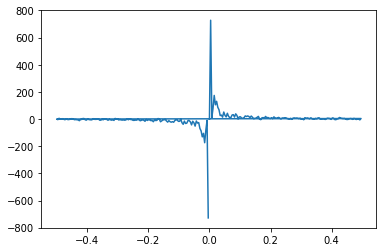

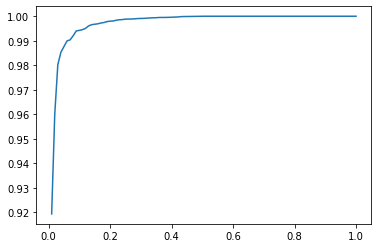

In [ ]:
import matplotlib.pyplot as plt
fft_data , fre = historical.fft_analyse()

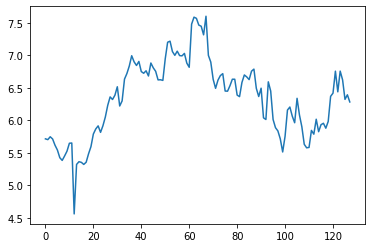

In [ ]:
plt.plot(historical.train_data[0:128])

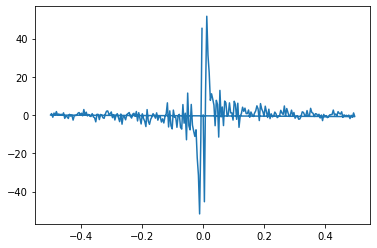

In [ ]:
da = historical.train_data[0:256]
ff = np.fft.fft(da,axis=0)
freq = np.fft.fftfreq(da.shape[-1])
plt.plot(freq, ff.imag)

In [ ]:
k = np.array([(da[i] + da[i+1] + da[i+2] + da[i+3])/4 for i in range(256 -4)])

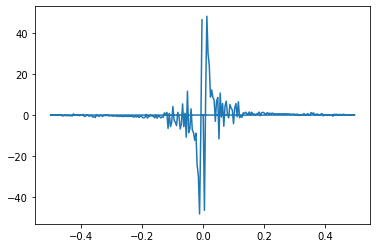

In [ ]:
ff = np.fft.fft(k,axis=0)
freq = np.fft.fftfreq(k.shape[-1])
plt.plot(freq, ff.imag)

In [ ]:
historical.K_fold_purged(10,2,10,0)
x_train,y_train,x_val,y_val = historical.split_data(4,True,True)
ep = [10 , 20]
l_size = [10 , 20]
lr = [0.002]
historical.k_fold_LSTM(x_train,y_train,x_val,y_val,11,ep,l_size,lr)

In [ ]:
x_train,y_train,x_val,y_val = historical.split_data(4,True,True)

In [ ]:
ep = [10 , 20]
l_size = [10 , 20]
lr = [0.002]
historical.k_fold_LSTM(x_train,y_train,x_val,y_val,11,ep,l_size,lr)

epoch :  10, layer_size : 10 , lr : 0.002000
epoch :  10, layer_size : 20 , lr : 0.002000
epoch :  20, layer_size : 10 , lr : 0.002000
epoch :  20, layer_size : 20 , lr : 0.002000


(10, 10, 0.002)

Epoch 1/30
69/69 [==============================] - 2s 10ms/step - loss: 0.6750 - accuracy: 0.6110 - val_loss: 0.7288 - val_accuracy: 0.4709
Epoch 2/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6594 - accuracy: 0.6165 - val_loss: 0.6806 - val_accuracy: 0.4975
Epoch 3/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6061 - accuracy: 0.6624 - val_loss: 0.6730 - val_accuracy: 0.6304
Epoch 4/30
69/69 [==============================] - 0s 7ms/step - loss: 0.5992 - accuracy: 0.6936 - val_loss: 0.7248 - val_accuracy: 0.5861
Epoch 5/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6011 - accuracy: 0.6661 - val_loss: 0.6621 - val_accuracy: 0.6203
Epoch 6/30
69/69 [==============================] - 0s 6ms/step - loss: 0.5831 - accuracy: 0.6945 - val_loss: 0.7583 - val_accuracy: 0.5747
Epoch 7/30
69/69 [==============================] - 0s 6ms/step - loss: 0.5984 - accuracy: 0.6954 - val_loss: 0.6377 - val_accuracy: 0.6595
Epoch 8/30
69/69 [=

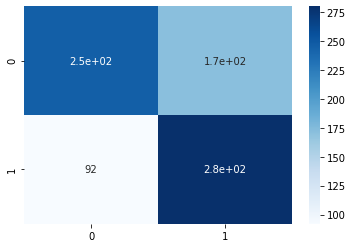

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=1,deep=True , one_d=True)
historical.evaluat_LSTM(30,10,11,0.002,True,False)

Epoch 1/30
69/69 [==============================] - 2s 10ms/step - loss: 0.6733 - accuracy: 0.5917 - val_loss: 0.7199 - val_accuracy: 0.4709
Epoch 2/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6554 - accuracy: 0.6101 - val_loss: 0.7202 - val_accuracy: 0.4709
Epoch 3/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6218 - accuracy: 0.6514 - val_loss: 0.6466 - val_accuracy: 0.6354
Epoch 4/30
69/69 [==============================] - 0s 7ms/step - loss: 0.5794 - accuracy: 0.6945 - val_loss: 0.6299 - val_accuracy: 0.6506
Epoch 5/30
69/69 [==============================] - 0s 7ms/step - loss: 0.5768 - accuracy: 0.7092 - val_loss: 0.6399 - val_accuracy: 0.6329
Epoch 6/30
69/69 [==============================] - 0s 6ms/step - loss: 0.5714 - accuracy: 0.7174 - val_loss: 0.6663 - val_accuracy: 0.6051
Epoch 7/30
69/69 [==============================] - 0s 6ms/step - loss: 0.5699 - accuracy: 0.7119 - val_loss: 0.6299 - val_accuracy: 0.6557
Epoch 8/30
69/69 [=

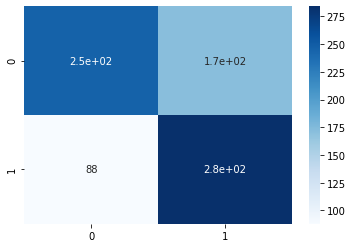

In [ ]:
historical.evaluat_GRU(30,10,11,0.002,True,False)

[0]	validation_0-auc:0.697105
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.698867
[2]	validation_0-auc:0.702841
[3]	validation_0-auc:0.706182
[4]	validation_0-auc:0.699127
[5]	validation_0-auc:0.701057
[6]	validation_0-auc:0.705224
[7]	validation_0-auc:0.708346
[8]	validation_0-auc:0.711443
[9]	validation_0-auc:0.711594
[10]	validation_0-auc:0.713292
[11]	validation_0-auc:0.713169
[12]	validation_0-auc:0.712989
[13]	validation_0-auc:0.713099
[14]	validation_0-auc:0.712488
[15]	validation_0-auc:0.710954
[16]	validation_0-auc:0.713594
[17]	validation_0-auc:0.713452
[18]	validation_0-auc:0.713829
[19]	validation_0-auc:0.712012
[20]	validation_0-auc:0.711883
[21]	validation_0-auc:0.711459
[22]	validation_0-auc:0.711288
[23]	validation_0-auc:0.711597
[24]	validation_0-auc:0.712266
[25]	validation_0-auc:0.709848
[26]	validation_0-auc:0.710491
[27]	validation_0-auc:0.710327
[28]	validation_0-auc:0.710822
[29]	validation_0-auc:0.710247
[30]	validation_

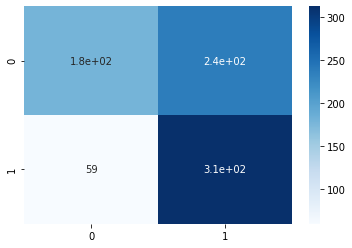

In [ ]:
historical.evaluat_XGboost(50,False)

In [ ]:
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)

Epoch 1/30
67/67 [==============================] - 2s 10ms/step - loss: 0.6772 - accuracy: 0.5960 - val_loss: 0.7047 - val_accuracy: 0.4756
Epoch 2/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6666 - accuracy: 0.5998 - val_loss: 0.7004 - val_accuracy: 0.4756
Epoch 3/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6436 - accuracy: 0.6159 - val_loss: 0.6642 - val_accuracy: 0.5059
Epoch 4/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6232 - accuracy: 0.6386 - val_loss: 0.6605 - val_accuracy: 0.5258
Epoch 5/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6080 - accuracy: 0.6802 - val_loss: 0.6800 - val_accuracy: 0.5099
Epoch 6/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6000 - accuracy: 0.6868 - val_loss: 0.6210 - val_accuracy: 0.6473
Epoch 7/30
67/67 [==============================] - 0s 6ms/step - loss: 0.5822 - accuracy: 0.6954 - val_loss: 0.6229 - val_accuracy: 0.6579
Epoch 8/30
67/67 [=

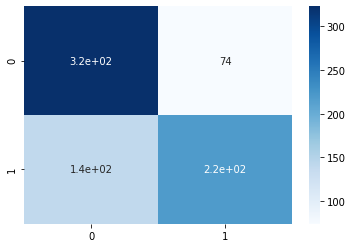

In [ ]:
historical.evaluat_LSTM(30,10,11,0.002,True,True)

Epoch 1/30
67/67 [==============================] - 2s 9ms/step - loss: 0.6718 - accuracy: 0.6036 - val_loss: 0.7040 - val_accuracy: 0.4756
Epoch 2/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6497 - accuracy: 0.6017 - val_loss: 0.6845 - val_accuracy: 0.4795
Epoch 3/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6109 - accuracy: 0.6509 - val_loss: 0.6566 - val_accuracy: 0.5429
Epoch 4/30
67/67 [==============================] - 0s 6ms/step - loss: 0.5896 - accuracy: 0.7001 - val_loss: 0.6241 - val_accuracy: 0.6433
Epoch 5/30
67/67 [==============================] - 0s 6ms/step - loss: 0.5603 - accuracy: 0.7360 - val_loss: 0.6195 - val_accuracy: 0.6486
Epoch 6/30
67/67 [==============================] - 0s 6ms/step - loss: 0.5581 - accuracy: 0.7247 - val_loss: 0.6011 - val_accuracy: 0.6843
Epoch 7/30
67/67 [==============================] - 0s 6ms/step - loss: 0.5550 - accuracy: 0.7389 - val_loss: 0.5912 - val_accuracy: 0.7001
Epoch 8/30
67/67 [==

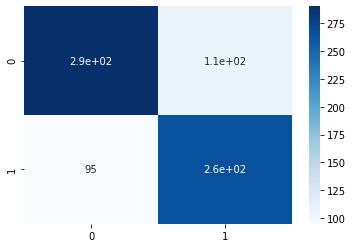

In [ ]:
historical.evaluat_GRU(30,10,11,0.002,True,True)

[0]	validation_0-auc:0.763368
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.773086
[2]	validation_0-auc:0.774055
[3]	validation_0-auc:0.775339
[4]	validation_0-auc:0.77867
[5]	validation_0-auc:0.778596
[6]	validation_0-auc:0.775623
[7]	validation_0-auc:0.773443
[8]	validation_0-auc:0.774073
[9]	validation_0-auc:0.774885
[10]	validation_0-auc:0.77437
[11]	validation_0-auc:0.773307
[12]	validation_0-auc:0.771813
[13]	validation_0-auc:0.772219
[14]	validation_0-auc:0.771837
[15]	validation_0-auc:0.771208
[16]	validation_0-auc:0.772348
[17]	validation_0-auc:0.771376
[18]	validation_0-auc:0.771554
[19]	validation_0-auc:0.76843
[20]	validation_0-auc:0.768577
[21]	validation_0-auc:0.768916
[22]	validation_0-auc:0.768605
[23]	validation_0-auc:0.767128
[24]	validation_0-auc:0.76814
[25]	validation_0-auc:0.768349
[26]	validation_0-auc:0.768279
[27]	validation_0-auc:0.768049
[28]	validation_0-auc:0.769221
[29]	validation_0-auc:0.770032
[30]	validation_0-au

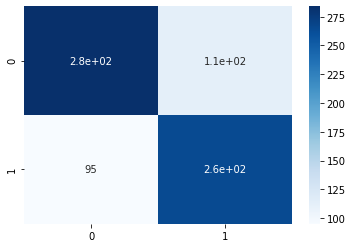

In [ ]:
historical.evaluat_XGboost(50,True)

In [ ]:
x= historical.tabel()
print(x)

+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1 score      |          MI         |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|              LSTM             | 0.6658227848101266 | 0.6194690265486725 | 0.7526881720430108 | 0.6796116504854369 | 0.06088438253042108 |
|              GRU              | 0.6708860759493671 | 0.6228070175438597 | 0.7634408602150538 | 0.6859903381642513 | 0.06514353506284376 |
|            XGBoost            | 0.6240506329113924 | 0.5680580762250453 | 0.8413978494623656 | 0.6782231852654387 | 0.04541084417462207 |
|   LSTM with 44 previous data  | 0.7159841479524438 | 0.7474402730375427 | 0.6083333333333333 | 0.6707503828483921 | 0.09679681914591437 |
|   GRU with 44 prev

In [ ]:
resa = []
resa.append(historical.LSTM_result)
resa.append(historical.GRU_result)
resa.append(historical.XGboost_result)
resa.append(historical.LSTM_bata_result)
resa.append(historical.GRU_bata_result)
resa.append(historical.XGboost_bata_result)

In [ ]:
res

[['LSTM',
  0.6481012658227848,
  0.591796875,
  0.8145161290322581,
  0.6855203619909503,
  0.056019623937848234],
 ['GRU',
  0.6050632911392405,
  0.5503355704697986,
  0.8817204301075269,
  0.6776859504132231,
  0.04087464080228018],
 ['XGBoost',
  0.6240506329113924,
  0.5680580762250453,
  0.8413978494623656,
  0.6782231852654387,
  0.04541084417462207],
 ['LSTM with 44 previous data',
  0.7186261558784677,
  0.7082152974504249,
  0.6944444444444444,
  0.7012622720897614,
  0.09794002693721493],
 ['GRU with 44 previous data',
  0.7186261558784677,
  0.6860759493670886,
  0.7527777777777778,
  0.7178807947019866,
  0.10057635120935743],
 ['XGBoost with 44 previous data',
  0.7252311756935271,
  0.701058201058201,
  0.7361111111111112,
  0.7181571815718157,
  0.10547135557134937]]

In [ ]:
Result = pd.DataFrame()

In [ ]:
for x in resa:
  dic = {
    "Name": "Tesla",
    "Model": x[0],
    "acc": x[1],
    "Perc": x[2] , 
    "recal": x[3] , 
    "f1" :x[4] , 
    "MI" : x[5]
  }
  Result = Result.append(dic,ignore_index=True)

In [ ]:
Result

MI                          Model   Name  ...       acc        f1     recal
0  0.060884                           LSTM  Tesla  ...  0.665823  0.679612  0.752688
1  0.065144                            GRU  Tesla  ...  0.670886  0.685990  0.763441
2  0.045411                        XGBoost  Tesla  ...  0.624051  0.678223  0.841398
3  0.096797     LSTM with 44 previous data  Tesla  ...  0.715984  0.670750  0.608333
4  0.112927      GRU with 44 previous data  Tesla  ...  0.733157  0.724044  0.736111
5  0.105471  XGBoost with 44 previous data  Tesla  ...  0.725231  0.718157  0.736111

[6 rows x 7 columns]

## LIVE


In [ ]:

dfs = pd.read_csv("LIVE.csv")
dfs = dfs[::-1].reset_index()



In [ ]:
dfs

index        Date Close/Last   Volume      Open      High      Low
0      2515  08/04/2011    $4.2599    448.0   $4.3399   $4.3399  $4.2599
1      2514  08/05/2011    $4.1999    494.0   $4.2599   $4.2599  $4.1399
2      2513  08/08/2011    $3.5599    818.0   $4.0199   $4.0201  $3.5599
3      2512  08/09/2011    $3.5599    560.0   $3.9799   $3.9799  $3.5599
4      2511  08/10/2011    $4.2799   2533.0   $3.6599   $4.7399  $3.4199
...     ...         ...        ...      ...       ...       ...      ...
2511      4  07/28/2021     $62.58  27702.0     $63.9    $66.48   $61.66
2512      3  07/29/2021    $64.025   6751.0    $62.73  $65.7999   $62.73
2513      2  07/30/2021      $63.8   8099.0  $64.8059  $64.8059  $62.245
2514      1  08/02/2021     $64.22   4358.0     $63.7    $64.38   $62.69
2515      0  08/03/2021     $62.58  26605.0       $60    $64.98      $60

[2516 rows x 7 columns]

In [ ]:
dfs['Close/Last'] = np.array([float(x[1:]) for x in dfs['Close/Last']])

In [ ]:


closing_price , label = visualize(dfs,'Close/Last','Date',0.27,100,2000)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=1200,test_index_end=2000)



Epoch 1/30
69/69 [==============================] - 2s 11ms/step - loss: 0.6742 - accuracy: 0.6064 - val_loss: 0.6644 - val_accuracy: 0.6165
Epoch 2/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6663 - accuracy: 0.6174 - val_loss: 0.6604 - val_accuracy: 0.6165
Epoch 3/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6385 - accuracy: 0.6431 - val_loss: 0.6319 - val_accuracy: 0.6722
Epoch 4/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6318 - accuracy: 0.6615 - val_loss: 0.6231 - val_accuracy: 0.6709
Epoch 5/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6235 - accuracy: 0.6826 - val_loss: 0.6189 - val_accuracy: 0.6886
Epoch 6/30
69/69 [==============================] - 1s 7ms/step - loss: 0.6217 - accuracy: 0.6817 - val_loss: 0.6220 - val_accuracy: 0.6987
Epoch 7/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6140 - accuracy: 0.6954 - val_loss: 0.6102 - val_accuracy: 0.6987
Epoch 8/30
69/69 [=

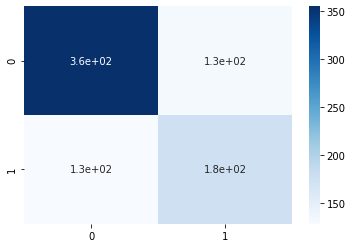

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=1,deep=True , one_d=True)
historical.evaluat_LSTM(30,10,11,0.002,True,False)

Epoch 1/30
69/69 [==============================] - 2s 10ms/step - loss: 0.6704 - accuracy: 0.6147 - val_loss: 0.6607 - val_accuracy: 0.6165
Epoch 2/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6486 - accuracy: 0.6248 - val_loss: 0.6459 - val_accuracy: 0.6190
Epoch 3/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6239 - accuracy: 0.6560 - val_loss: 0.6354 - val_accuracy: 0.6532
Epoch 4/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6048 - accuracy: 0.6826 - val_loss: 0.6201 - val_accuracy: 0.6443
Epoch 5/30
69/69 [==============================] - 0s 6ms/step - loss: 0.5924 - accuracy: 0.6972 - val_loss: 0.6080 - val_accuracy: 0.6684
Epoch 6/30
69/69 [==============================] - 0s 6ms/step - loss: 0.5887 - accuracy: 0.7028 - val_loss: 0.6100 - val_accuracy: 0.6646
Epoch 7/30
69/69 [==============================] - 0s 6ms/step - loss: 0.5712 - accuracy: 0.7147 - val_loss: 0.6079 - val_accuracy: 0.6570
Epoch 8/30
69/69 [=

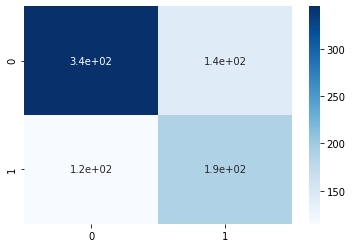

In [ ]:
historical.evaluat_GRU(30,10,11,0.002,True,False)

[0]	validation_0-auc:0.700283
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.703719
[2]	validation_0-auc:0.702835
[3]	validation_0-auc:0.703238
[4]	validation_0-auc:0.705396
[5]	validation_0-auc:0.703699
[6]	validation_0-auc:0.710056
[7]	validation_0-auc:0.713173
[8]	validation_0-auc:0.711763
[9]	validation_0-auc:0.710415
[10]	validation_0-auc:0.710632
[11]	validation_0-auc:0.713037
[12]	validation_0-auc:0.711675
[13]	validation_0-auc:0.710964
[14]	validation_0-auc:0.71116
[15]	validation_0-auc:0.710926
[16]	validation_0-auc:0.709889
[17]	validation_0-auc:0.709232
[18]	validation_0-auc:0.709205
[19]	validation_0-auc:0.708622
[20]	validation_0-auc:0.709036
[21]	validation_0-auc:0.705688
[22]	validation_0-auc:0.707219
[23]	validation_0-auc:0.708165
[24]	validation_0-auc:0.707836
[25]	validation_0-auc:0.707833
[26]	validation_0-auc:0.710713
[27]	validation_0-auc:0.710503
[28]	validation_0-auc:0.710435
[29]	validation_0-auc:0.710469
[30]	validation_0

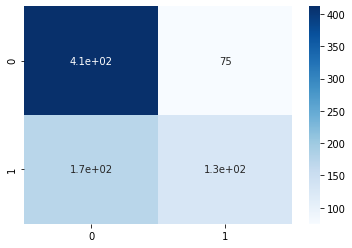

In [ ]:
historical.evaluat_XGboost(50,False)

Epoch 1/30
67/67 [==============================] - 2s 11ms/step - loss: 0.6728 - accuracy: 0.6197 - val_loss: 0.6512 - val_accuracy: 0.6433
Epoch 2/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6643 - accuracy: 0.6263 - val_loss: 0.6511 - val_accuracy: 0.6433
Epoch 3/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6652 - accuracy: 0.6263 - val_loss: 0.6493 - val_accuracy: 0.6433
Epoch 4/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6628 - accuracy: 0.6263 - val_loss: 0.6478 - val_accuracy: 0.6433
Epoch 5/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6596 - accuracy: 0.6272 - val_loss: 0.6429 - val_accuracy: 0.6433
Epoch 6/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6564 - accuracy: 0.6272 - val_loss: 0.6415 - val_accuracy: 0.6433
Epoch 7/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6563 - accuracy: 0.6254 - val_loss: 0.6342 - val_accuracy: 0.6433
Epoch 8/30
67/67 [=

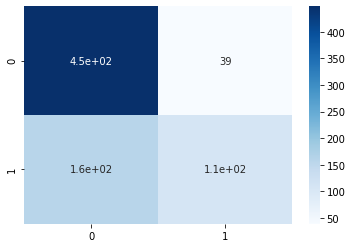

In [ ]:
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)


historical.evaluat_LSTM(30,10,11,0.002,True,True)




Epoch 1/30
67/67 [==============================] - 2s 11ms/step - loss: 0.6743 - accuracy: 0.6225 - val_loss: 0.6557 - val_accuracy: 0.6433
Epoch 2/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6552 - accuracy: 0.6244 - val_loss: 0.6430 - val_accuracy: 0.6433
Epoch 3/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6532 - accuracy: 0.6291 - val_loss: 0.6395 - val_accuracy: 0.6433
Epoch 4/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6455 - accuracy: 0.6339 - val_loss: 0.6281 - val_accuracy: 0.6433
Epoch 5/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6335 - accuracy: 0.6490 - val_loss: 0.6162 - val_accuracy: 0.6460
Epoch 6/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6299 - accuracy: 0.6500 - val_loss: 0.6164 - val_accuracy: 0.6565
Epoch 7/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6311 - accuracy: 0.6613 - val_loss: 0.5976 - val_accuracy: 0.6592
Epoch 8/30
67/67 [=

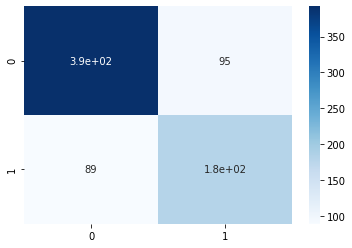

In [ ]:
historical.evaluat_GRU(30,10,11,0.002,True,True)




[0]	validation_0-auc:0.747802
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.754605
[2]	validation_0-auc:0.7624
[3]	validation_0-auc:0.764724
[4]	validation_0-auc:0.761221
[5]	validation_0-auc:0.761495
[6]	validation_0-auc:0.769678
[7]	validation_0-auc:0.765488
[8]	validation_0-auc:0.763883
[9]	validation_0-auc:0.766804
[10]	validation_0-auc:0.76694
[11]	validation_0-auc:0.768325
[12]	validation_0-auc:0.770237
[13]	validation_0-auc:0.76996
[14]	validation_0-auc:0.773914
[15]	validation_0-auc:0.780409
[16]	validation_0-auc:0.783196
[17]	validation_0-auc:0.787912
[18]	validation_0-auc:0.786683
[19]	validation_0-auc:0.787212
[20]	validation_0-auc:0.788809
[21]	validation_0-auc:0.791718
[22]	validation_0-auc:0.792619
[23]	validation_0-auc:0.794076
[24]	validation_0-auc:0.795452
[25]	validation_0-auc:0.79889
[26]	validation_0-auc:0.797753
[27]	validation_0-auc:0.795471
[28]	validation_0-auc:0.794357
[29]	validation_0-auc:0.795308
[30]	validation_0-auc

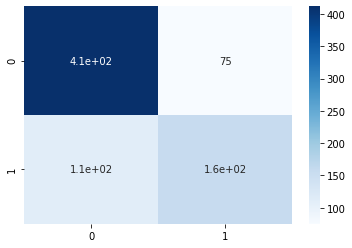

In [ ]:
historical.evaluat_XGboost(50,True)



In [ ]:
print(historical.tabel())

+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1 score      |          MI         |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|              LSTM             | 0.6708860759493671 | 0.5700325732899023 | 0.5775577557755776 | 0.5737704918032788 | 0.04670777840977322 |
|              GRU              | 0.6746835443037975 | 0.5696969696969697 | 0.6204620462046204 | 0.593996840442338  | 0.05286600961831356 |
|            XGBoost            | 0.6860759493670886 | 0.6341463414634146 | 0.429042904290429  | 0.5118110236220472 | 0.04572472835980165 |
|   LSTM with 44 previous data  | 0.7371202113606341 | 0.738255033557047  | 0.4074074074074074 | 0.5250596658711216 | 0.07543199624255034 |
|   GRU with 44 prev

In [ ]:


resl = []
resl.append(historical.LSTM_result)
resl.append(historical.GRU_result)
resl.append(historical.XGboost_result)
resl.append(historical.LSTM_bata_result)
resl.append(historical.GRU_bata_result)
resl.append(historical.XGboost_bata_result)






In [ ]:
for x in resl:
  dic = {
    "Name": "LIVE",
    "Model": x[0],
    "acc": x[1],
    "Perc": x[2] , 
    "recal": x[3] , 
    "f1" :x[4] , 
    "MI" : x[5]
  }
  Result = Result.append(dic,ignore_index=True)

In [ ]:
Result

MI                          Model  ...        f1     recal
0   0.060884                           LSTM  ...  0.679612  0.752688
1   0.065144                            GRU  ...  0.685990  0.763441
2   0.045411                        XGBoost  ...  0.678223  0.841398
3   0.096797     LSTM with 44 previous data  ...  0.670750  0.608333
4   0.112927      GRU with 44 previous data  ...  0.724044  0.736111
5   0.105471  XGBoost with 44 previous data  ...  0.718157  0.736111
6   0.051409                           LSTM  ...  0.543071  0.478548
7   0.056023                            GRU  ...  0.504202  0.396040
8   0.045725                        XGBoost  ...  0.511811  0.429043
9   0.116046     LSTM with 44 previous data  ...  0.665428  0.662963
10  0.134007      GRU with 44 previous data  ...  0.647702  0.548148
11  0.098931  XGBoost with 44 previous data  ...  0.628231  0.585185

[12 rows x 7 columns]

##MRCY

In [ ]:

dfs = pd.read_csv("MRCY.csv")
dfs = dfs[::-1].reset_index()


In [ ]:
dfs

index        Date Close/Last  Volume    Open     High     Low
0      2514  08/05/2011     $16.29  284911  $16.72    $16.9  $16.05
1      2513  08/08/2011     $15.15  470311  $15.81   $16.44  $15.11
2      2512  08/09/2011     $15.78  553031  $15.76      $16  $14.44
3      2511  08/10/2011      $14.6  273537  $15.36   $15.71  $14.48
4      2510  08/11/2011     $15.01  377677  $14.87    $15.3  $14.78
...     ...         ...        ...     ...     ...      ...     ...
2510      4  07/28/2021     $65.94  227921  $65.82   $66.64  $65.81
2511      3  07/29/2021     $65.83  255526  $66.27   $66.66  $65.65
2512      2  07/30/2021        $66  208753  $65.53  $66.275  $65.47
2513      1  08/02/2021     $65.21  236307  $66.42   $67.98  $65.17
2514      0  08/03/2021     $63.57  504648   $65.4    $65.4  $63.18

[2515 rows x 7 columns]

In [ ]:
dfs['Close/Last'] = np.array([float(x[1:]) for x in dfs['Close/Last']])

Epoch 1/30
69/69 [==============================] - 2s 11ms/step - loss: 0.6952 - accuracy: 0.5018 - val_loss: 0.6716 - val_accuracy: 0.8291
Epoch 2/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4991 - val_loss: 0.6634 - val_accuracy: 0.8291
Epoch 3/30
69/69 [==============================] - 1s 8ms/step - loss: 0.6925 - accuracy: 0.5009 - val_loss: 0.6807 - val_accuracy: 0.8316
Epoch 4/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.5211 - val_loss: 0.6570 - val_accuracy: 0.8316
Epoch 5/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6762 - accuracy: 0.5807 - val_loss: 0.6597 - val_accuracy: 0.6000
Epoch 6/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6525 - accuracy: 0.6064 - val_loss: 0.5540 - val_accuracy: 0.7456
Epoch 7/30
69/69 [==============================] - 0s 7ms/step - loss: 0.6434 - accuracy: 0.6394 - val_loss: 0.5827 - val_accuracy: 0.7316
Epoch 8/30
69/69 [=

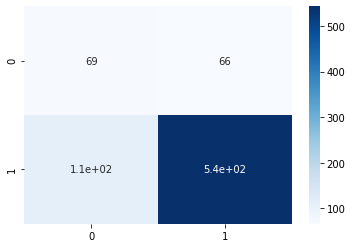

In [ ]:
closing_price , label = visualize(dfs,'Close/Last','Date',0.17,100,2000)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=1200,test_index_end=2000)

#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=1,deep=True , one_d=True)
historical.evaluat_LSTM(30,10,11,0.002,True,False)

Epoch 1/30
69/69 [==============================] - 2s 14ms/step - loss: 0.6923 - accuracy: 0.5055 - val_loss: 0.6869 - val_accuracy: 0.7747
Epoch 2/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6856 - accuracy: 0.5633 - val_loss: 0.7097 - val_accuracy: 0.2481
Epoch 3/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6762 - accuracy: 0.5890 - val_loss: 0.6491 - val_accuracy: 0.6975
Epoch 4/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6542 - accuracy: 0.6128 - val_loss: 0.5921 - val_accuracy: 0.7405
Epoch 5/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6428 - accuracy: 0.6312 - val_loss: 0.6748 - val_accuracy: 0.5911
Epoch 6/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6460 - accuracy: 0.6404 - val_loss: 0.6431 - val_accuracy: 0.6405
Epoch 7/30
69/69 [==============================] - 0s 6ms/step - loss: 0.6442 - accuracy: 0.6330 - val_loss: 0.6340 - val_accuracy: 0.6519
Epoch 8/30
69/69 [=

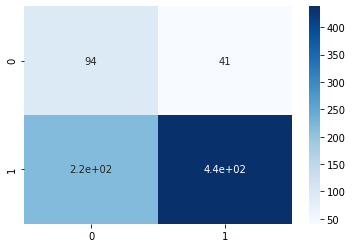

In [ ]:
historical.evaluat_GRU(30,10,11,0.002,True,False)

[0]	validation_0-auc:0.723591
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.730172
[2]	validation_0-auc:0.731015
[3]	validation_0-auc:0.740192
[4]	validation_0-auc:0.739389
[5]	validation_0-auc:0.740237
[6]	validation_0-auc:0.741306
[7]	validation_0-auc:0.740368
[8]	validation_0-auc:0.739825
[9]	validation_0-auc:0.755363
[10]	validation_0-auc:0.754323
[11]	validation_0-auc:0.754594
[12]	validation_0-auc:0.758111
[13]	validation_0-auc:0.757829
[14]	validation_0-auc:0.758349
[15]	validation_0-auc:0.759836
[16]	validation_0-auc:0.760181
[17]	validation_0-auc:0.760565
[18]	validation_0-auc:0.758061
[19]	validation_0-auc:0.757795
[20]	validation_0-auc:0.756426
[21]	validation_0-auc:0.760464
[22]	validation_0-auc:0.760209
[23]	validation_0-auc:0.760028
[24]	validation_0-auc:0.763099
[25]	validation_0-auc:0.76423
[26]	validation_0-auc:0.764654
[27]	validation_0-auc:0.767854
[28]	validation_0-auc:0.764857
[29]	validation_0-auc:0.767809
[30]	validation_0

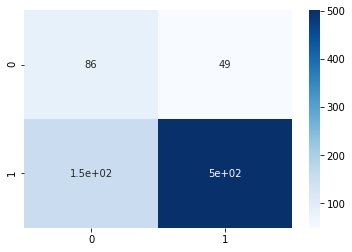

In [ ]:
historical.evaluat_XGboost(50,False)

In [ ]:
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)

Epoch 1/30
67/67 [==============================] - 2s 11ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6726 - val_accuracy: 0.8217
Epoch 2/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.5326 - val_loss: 0.6710 - val_accuracy: 0.6513
Epoch 3/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6637 - accuracy: 0.6149 - val_loss: 0.6481 - val_accuracy: 0.6301
Epoch 4/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6447 - accuracy: 0.6679 - val_loss: 0.6391 - val_accuracy: 0.6684
Epoch 5/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6291 - accuracy: 0.6755 - val_loss: 0.6191 - val_accuracy: 0.6803
Epoch 6/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6241 - accuracy: 0.6812 - val_loss: 0.6238 - val_accuracy: 0.6935
Epoch 7/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6209 - accuracy: 0.6831 - val_loss: 0.6402 - val_accuracy: 0.6869
Epoch 8/30
67/67 [=

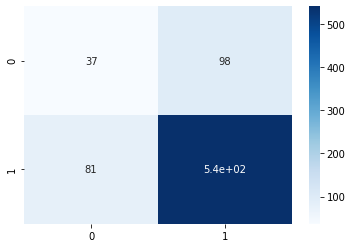

In [ ]:
historical.evaluat_LSTM(30,10,11,0.002,True,True)

Epoch 1/30
67/67 [==============================] - 2s 10ms/step - loss: 0.6845 - accuracy: 0.6036 - val_loss: 0.6247 - val_accuracy: 0.7886
Epoch 2/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6637 - accuracy: 0.6272 - val_loss: 0.6056 - val_accuracy: 0.7173
Epoch 3/30
67/67 [==============================] - 0s 7ms/step - loss: 0.6230 - accuracy: 0.6973 - val_loss: 0.5629 - val_accuracy: 0.7226
Epoch 4/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6113 - accuracy: 0.7162 - val_loss: 0.5919 - val_accuracy: 0.6856
Epoch 5/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6065 - accuracy: 0.7162 - val_loss: 0.5993 - val_accuracy: 0.6724
Epoch 6/30
67/67 [==============================] - 0s 6ms/step - loss: 0.6009 - accuracy: 0.7171 - val_loss: 0.5580 - val_accuracy: 0.7160
Epoch 7/30
67/67 [==============================] - 0s 6ms/step - loss: 0.5874 - accuracy: 0.7332 - val_loss: 0.5689 - val_accuracy: 0.7041
Epoch 8/30
67/67 [=

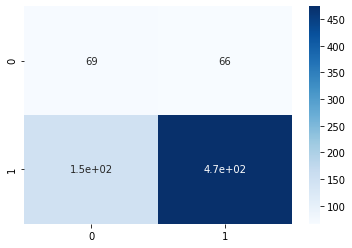

In [ ]:
historical.evaluat_GRU(30,10,11,0.002,True,True)

[0]	validation_0-auc:0.665345
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.6539
[2]	validation_0-auc:0.649917
[3]	validation_0-auc:0.672544
[4]	validation_0-auc:0.669876
[5]	validation_0-auc:0.65936
[6]	validation_0-auc:0.659468
[7]	validation_0-auc:0.667488
[8]	validation_0-auc:0.658741
[9]	validation_0-auc:0.660915
[10]	validation_0-auc:0.65596
[11]	validation_0-auc:0.65543
[12]	validation_0-auc:0.654222
[13]	validation_0-auc:0.654543
[14]	validation_0-auc:0.648422
[15]	validation_0-auc:0.651239
[16]	validation_0-auc:0.65683
[17]	validation_0-auc:0.655323
[18]	validation_0-auc:0.658956
[19]	validation_0-auc:0.660724
[20]	validation_0-auc:0.657991
[21]	validation_0-auc:0.654341
[22]	validation_0-auc:0.653995
[23]	validation_0-auc:0.653555
[24]	validation_0-auc:0.652173
[25]	validation_0-auc:0.654067
[26]	validation_0-auc:0.64866
[27]	validation_0-auc:0.647755
[28]	validation_0-auc:0.648291
[29]	validation_0-auc:0.64713
[30]	validation_0-auc:0.

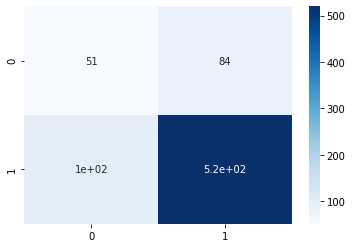

In [ ]:
historical.evaluat_XGboost(50,True)

In [ ]:
x= historical.tabel()
print(x)


res = []
res.append(historical.LSTM_result)
res.append(historical.GRU_result)
res.append(historical.XGboost_result)
res.append(historical.LSTM_bata_result)
res.append(historical.GRU_bata_result)
res.append(historical.XGboost_bata_result)




for x in res:
  dic = {
    "Name": "MRCY",
    "Model": x[0],
    "acc": x[1],
    "Perc": x[2] , 
    "recal": x[3] , 
    "f1" :x[4] , 
    "MI" : x[5]
  }
  Result = Result.append(dic,ignore_index=True)

+-------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1 score      |          MI          |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
|              LSTM             | 0.7962025316455696 | 0.8311499272197962 | 0.926948051948052  | 0.8764389869531849 | 0.043038909244478146 |
|              GRU              | 0.7544303797468355 | 0.872791519434629  | 0.801948051948052  | 0.8358714043993232 | 0.05881976190908733  |
|            XGBoost            | 0.759493670886076  | 0.8723776223776224 | 0.810064935064935  |  0.84006734006734  | 0.06022576216853928  |
|   LSTM with 44 previous data  | 0.7569352708058125 | 0.8265139116202946 | 0.8662092624356775 | 0.845896147403685  | 0.033480562109539314 |
|   GRU with 

##001_china

In [ ]:

dfs = pd.read_excel("000001data.xlsx")




In [ ]:
dfs

DATE  openingprice  ...     volume       amounts
0    1990-12-19         96.05  ...       1260        494311
1    1990-12-20        104.30  ...        197         84992
2    1990-12-21        109.07  ...         28         16096
3    1990-12-24        113.57  ...         32         31063
4    1990-12-25        120.09  ...         15          6510
...         ...           ...  ...        ...           ...
6851 2018-12-24       2506.74  ...   97339856   85760933888
6852 2018-12-25       2503.95  ...  140670560  114766012416
6853 2018-12-26       2501.12  ...  108799632   93989535744
6854 2018-12-27       2527.72  ...  135406848  112479764480
6855 2018-12-28       2483.62  ...  119245248  105980854272

[6856 rows x 7 columns]

In [ ]:


closing_price , label = visualize(dfs,'closingprice','DATE',0.15,100,6011)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=3011,test_index_end=6600)

#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=1,deep=True , one_d=True)


Epoch 1/30
182/182 [==============================] - 3s 9ms/step - loss: 0.6892 - accuracy: 0.5419 - val_loss: 0.6800 - val_accuracy: 0.5725
Epoch 2/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6387 - accuracy: 0.6463 - val_loss: 0.6328 - val_accuracy: 0.6357
Epoch 3/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5982 - accuracy: 0.6963 - val_loss: 0.6063 - val_accuracy: 0.6837
Epoch 4/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5998 - accuracy: 0.6970 - val_loss: 0.6068 - val_accuracy: 0.6901
Epoch 5/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5901 - accuracy: 0.7122 - val_loss: 0.6058 - val_accuracy: 0.6862
Epoch 6/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5889 - accuracy: 0.7056 - val_loss: 0.6054 - val_accuracy: 0.6820
Epoch 7/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5751 - accuracy: 0.7177 - val_loss: 0.6534 - val_accuracy: 0.6035
Epoch 

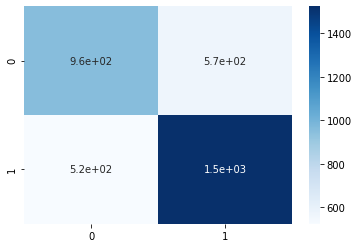

In [ ]:
historical.evaluat_LSTM(30,10,11,0.002,True,False)


Epoch 1/30
182/182 [==============================] - 3s 8ms/step - loss: 0.6830 - accuracy: 0.5567 - val_loss: 0.6719 - val_accuracy: 0.6832
Epoch 2/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6150 - accuracy: 0.6946 - val_loss: 0.6121 - val_accuracy: 0.6723
Epoch 3/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5836 - accuracy: 0.7098 - val_loss: 0.6035 - val_accuracy: 0.6770
Epoch 4/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5774 - accuracy: 0.7115 - val_loss: 0.5969 - val_accuracy: 0.6862
Epoch 5/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5690 - accuracy: 0.7194 - val_loss: 0.5907 - val_accuracy: 0.6904
Epoch 6/30
182/182 [==============================] - 1s 8ms/step - loss: 0.5684 - accuracy: 0.7229 - val_loss: 0.5873 - val_accuracy: 0.6929
Epoch 7/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5564 - accuracy: 0.7215 - val_loss: 0.5854 - val_accuracy: 0.6932
Epoch 

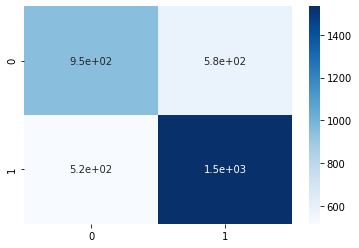

In [ ]:
historical.evaluat_GRU(30,10,11,0.002,True,False)

[0]	validation_0-auc:0.734416
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.734325
[2]	validation_0-auc:0.734393
[3]	validation_0-auc:0.735076
[4]	validation_0-auc:0.735264
[5]	validation_0-auc:0.735286
[6]	validation_0-auc:0.735599
[7]	validation_0-auc:0.744103
[8]	validation_0-auc:0.745366
[9]	validation_0-auc:0.746046
[10]	validation_0-auc:0.746146
[11]	validation_0-auc:0.747395
[12]	validation_0-auc:0.747888
[13]	validation_0-auc:0.747522
[14]	validation_0-auc:0.747043
[15]	validation_0-auc:0.747946
[16]	validation_0-auc:0.747434
[17]	validation_0-auc:0.747972
[18]	validation_0-auc:0.747534
[19]	validation_0-auc:0.748226
[20]	validation_0-auc:0.749208
[21]	validation_0-auc:0.749495
[22]	validation_0-auc:0.749326
[23]	validation_0-auc:0.749525
[24]	validation_0-auc:0.749297
[25]	validation_0-auc:0.74948
[26]	validation_0-auc:0.749458
[27]	validation_0-auc:0.749654
[28]	validation_0-auc:0.74991
[29]	validation_0-auc:0.749682
[30]	validation_0-

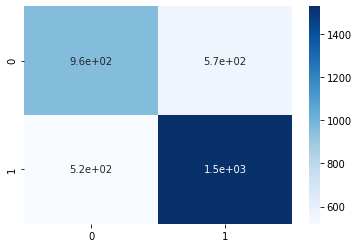

In [ ]:
historical.evaluat_XGboost(50,False)



Epoch 1/30
180/180 [==============================] - 3s 9ms/step - loss: 0.6890 - accuracy: 0.5307 - val_loss: 0.6621 - val_accuracy: 0.5933
Epoch 2/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6479 - accuracy: 0.6457 - val_loss: 0.5923 - val_accuracy: 0.7129
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6387 - accuracy: 0.6566 - val_loss: 0.6054 - val_accuracy: 0.6478
Epoch 4/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6187 - accuracy: 0.6709 - val_loss: 0.6051 - val_accuracy: 0.7188
Epoch 5/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6011 - accuracy: 0.6918 - val_loss: 0.5791 - val_accuracy: 0.7155
Epoch 6/30
180/180 [==============================] - 1s 8ms/step - loss: 0.5921 - accuracy: 0.7071 - val_loss: 0.5663 - val_accuracy: 0.7163
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5849 - accuracy: 0.7015 - val_loss: 0.5546 - val_accuracy: 0.7276
Epoch 

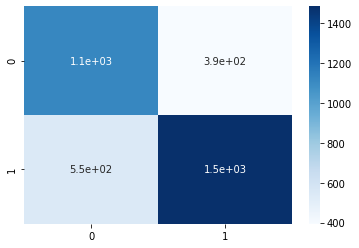

In [ ]:
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)


historical.evaluat_LSTM(30,10,11,0.002,True,True)




Epoch 1/30
180/180 [==============================] - 2s 8ms/step - loss: 0.6735 - accuracy: 0.5910 - val_loss: 0.6533 - val_accuracy: 0.7225
Epoch 2/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6374 - accuracy: 0.6907 - val_loss: 0.6029 - val_accuracy: 0.6923
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5944 - accuracy: 0.7141 - val_loss: 0.5872 - val_accuracy: 0.7250
Epoch 4/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5738 - accuracy: 0.7291 - val_loss: 0.5560 - val_accuracy: 0.7236
Epoch 5/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5436 - accuracy: 0.7343 - val_loss: 0.5714 - val_accuracy: 0.6754
Epoch 6/30
180/180 [==============================] - 1s 8ms/step - loss: 0.5425 - accuracy: 0.7458 - val_loss: 0.5280 - val_accuracy: 0.7377
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5177 - accuracy: 0.7552 - val_loss: 0.5311 - val_accuracy: 0.7293
Epoch 

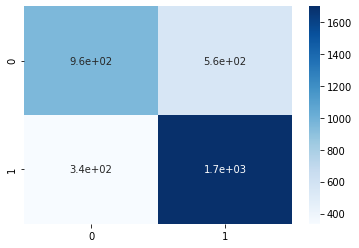

In [ ]:
historical.evaluat_GRU(30,10,11,0.002,True,True)



[0]	validation_0-auc:0.781263
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.787657
[2]	validation_0-auc:0.787927
[3]	validation_0-auc:0.789378
[4]	validation_0-auc:0.79358
[5]	validation_0-auc:0.792107
[6]	validation_0-auc:0.792783
[7]	validation_0-auc:0.795537
[8]	validation_0-auc:0.796072
[9]	validation_0-auc:0.795433
[10]	validation_0-auc:0.79577
[11]	validation_0-auc:0.797995
[12]	validation_0-auc:0.795925
[13]	validation_0-auc:0.797525
[14]	validation_0-auc:0.798339
[15]	validation_0-auc:0.798489
[16]	validation_0-auc:0.797947
[17]	validation_0-auc:0.797675
[18]	validation_0-auc:0.797216
[19]	validation_0-auc:0.797921
[20]	validation_0-auc:0.797717
[21]	validation_0-auc:0.798804
[22]	validation_0-auc:0.79742
[23]	validation_0-auc:0.796909
[24]	validation_0-auc:0.797208
[25]	validation_0-auc:0.797327
[26]	validation_0-auc:0.79764
[27]	validation_0-auc:0.797014
[28]	validation_0-auc:0.797856
[29]	validation_0-auc:0.79786
[30]	validation_0-auc

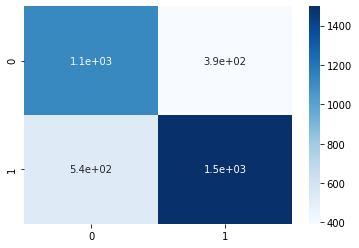

In [ ]:

historical.evaluat_XGboost(50,True)


In [ ]:

x= historical.tabel()
print(x)


res1 = []
res1.append(historical.LSTM_result)
res1.append(historical.GRU_result)
res1.append(historical.XGboost_result)
res1.append(historical.LSTM_bata_result)
res1.append(historical.GRU_bata_result)
res1.append(historical.XGboost_bata_result)






+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1 score      |          MI         |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|              LSTM             | 0.6932103939647947 | 0.7267525035765379 | 0.7437774524158126 | 0.7351664254703328 | 0.06980767426578705 |
|              GRU              | 0.694048616932104  | 0.7256385998107853 | 0.7486578818936066 | 0.7369685323084315 | 0.07014179124221728 |
|            XGBoost            | 0.6962838781782621 | 0.7294847328244275 | 0.7462176671547096 | 0.7377563329312424 | 0.07227621154066724 |
|   LSTM with 44 previous data  | 0.7340665538635082 | 0.7902023429179978 | 0.7299557304476144 | 0.7588851956021478 | 0.11227870960178662 |
|   GRU with 44 prev

In [ ]:
for x in res1:
  dic = {
    "Name": "001",
    "Model": x[0],
    "acc": x[1],
    "Perc": x[2] , 
    "recal": x[3] , 
    "f1" :x[4] , 
    "MI" : x[5]
  }
  Result = Result.append(dic,ignore_index=True)

## 004_china

In [ ]:
dfs = pd.read_excel("000004data.xlsx")

In [ ]:
dfs

DATE  openingprice  ...    volume       amounts
0    1991-01-02       16.7800  ...   23.0000  1.930000e+05
1    1991-01-10       16.2200  ...    1.0000  8.000000e+03
2    1991-01-14       15.9800  ...    1.0000  8.000000e+03
3    1991-01-15       15.9000  ...    1.0000  8.000000e+03
4    1991-01-17       15.7400  ...    1.0000  8.000000e+03
...         ...           ...  ...       ...           ...
6479 2018-12-21      128.8267  ...  278.6859  3.774242e+06
6480 2018-12-24      127.7459  ...  277.4831  3.780082e+06
6481 2018-12-25      128.8267  ...  276.0397  3.701756e+06
6482 2018-12-26      126.8313  ...  196.5355  2.656151e+06
6483 2018-12-27      130.4063  ...  237.5505  3.229032e+06

[6484 rows x 7 columns]

In [ ]:


closing_price , label = visualize(dfs,'closingprice','DATE',0.25,100,6011)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=3011,test_index_end=6600)

#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=1,deep=True , one_d=True)



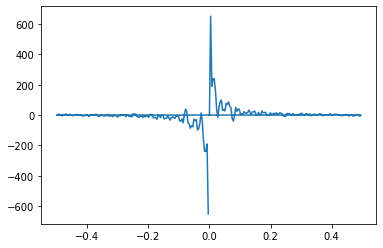

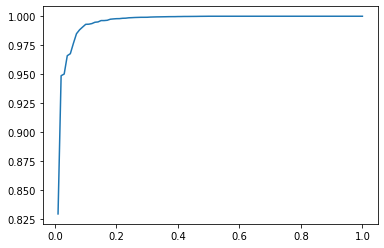

In [ ]:
a,b = historical.fft_analyse()

Epoch 1/30
182/182 [==============================] - 3s 8ms/step - loss: 0.6641 - accuracy: 0.5939 - val_loss: 0.6406 - val_accuracy: 0.6200
Epoch 2/30
182/182 [==============================] - 1s 8ms/step - loss: 0.6045 - accuracy: 0.6901 - val_loss: 0.7051 - val_accuracy: 0.5666
Epoch 3/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6043 - accuracy: 0.6867 - val_loss: 0.6358 - val_accuracy: 0.6284
Epoch 4/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5989 - accuracy: 0.6925 - val_loss: 0.6249 - val_accuracy: 0.6558
Epoch 5/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6008 - accuracy: 0.6929 - val_loss: 0.6184 - val_accuracy: 0.6679
Epoch 6/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5966 - accuracy: 0.6960 - val_loss: 0.6473 - val_accuracy: 0.6174
Epoch 7/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5939 - accuracy: 0.6942 - val_loss: 0.5970 - val_accuracy: 0.6806
Epoch 

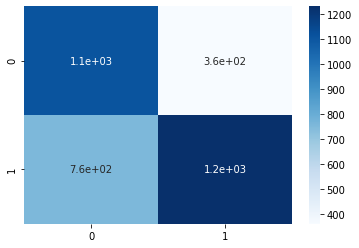

In [ ]:
historical.evaluat_LSTM(30,10,11,0.002,True,False)

Epoch 1/30
182/182 [==============================] - 3s 9ms/step - loss: 0.6590 - accuracy: 0.6105 - val_loss: 0.6225 - val_accuracy: 0.6581
Epoch 2/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5926 - accuracy: 0.6970 - val_loss: 0.6211 - val_accuracy: 0.6538
Epoch 3/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5924 - accuracy: 0.7042 - val_loss: 0.6194 - val_accuracy: 0.6520
Epoch 4/30
182/182 [==============================] - 1s 8ms/step - loss: 0.5784 - accuracy: 0.7104 - val_loss: 0.6007 - val_accuracy: 0.6772
Epoch 5/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5787 - accuracy: 0.7125 - val_loss: 0.5901 - val_accuracy: 0.6956
Epoch 6/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5700 - accuracy: 0.7170 - val_loss: 0.6199 - val_accuracy: 0.6503
Epoch 7/30
182/182 [==============================] - 1s 8ms/step - loss: 0.5676 - accuracy: 0.7170 - val_loss: 0.5878 - val_accuracy: 0.6867
Epoch 

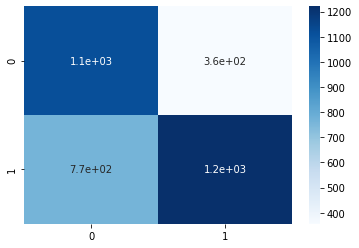

In [ ]:
historical.evaluat_GRU(30,10,11,0.002,True,False)




[0]	validation_0-auc:0.733027
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.742387
[2]	validation_0-auc:0.746201
[3]	validation_0-auc:0.750976
[4]	validation_0-auc:0.751098
[5]	validation_0-auc:0.750735
[6]	validation_0-auc:0.752366
[7]	validation_0-auc:0.752715
[8]	validation_0-auc:0.752947
[9]	validation_0-auc:0.752614
[10]	validation_0-auc:0.752763
[11]	validation_0-auc:0.753
[12]	validation_0-auc:0.753257
[13]	validation_0-auc:0.755047
[14]	validation_0-auc:0.755364
[15]	validation_0-auc:0.755899
[16]	validation_0-auc:0.756147
[17]	validation_0-auc:0.756891
[18]	validation_0-auc:0.757072
[19]	validation_0-auc:0.757782
[20]	validation_0-auc:0.757916
[21]	validation_0-auc:0.758169
[22]	validation_0-auc:0.758647
[23]	validation_0-auc:0.758511
[24]	validation_0-auc:0.758478
[25]	validation_0-auc:0.758779
[26]	validation_0-auc:0.759197
[27]	validation_0-auc:0.759033
[28]	validation_0-auc:0.759073
[29]	validation_0-auc:0.7593
[30]	validation_0-auc

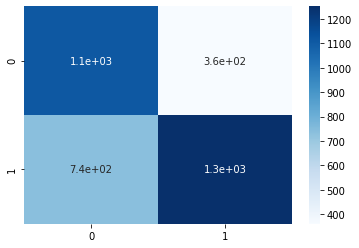

In [ ]:
historical.evaluat_XGboost(50,False)


Epoch 1/30
180/180 [==============================] - 3s 9ms/step - loss: 0.6805 - accuracy: 0.5746 - val_loss: 0.6404 - val_accuracy: 0.6452
Epoch 2/30
180/180 [==============================] - 1s 8ms/step - loss: 0.6519 - accuracy: 0.6520 - val_loss: 0.6572 - val_accuracy: 0.6085
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6297 - accuracy: 0.6607 - val_loss: 0.6027 - val_accuracy: 0.6837
Epoch 4/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6055 - accuracy: 0.6949 - val_loss: 0.5970 - val_accuracy: 0.6939
Epoch 5/30
180/180 [==============================] - 1s 8ms/step - loss: 0.5894 - accuracy: 0.6953 - val_loss: 0.6097 - val_accuracy: 0.6662
Epoch 6/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5757 - accuracy: 0.7036 - val_loss: 0.5814 - val_accuracy: 0.7085
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5672 - accuracy: 0.7165 - val_loss: 0.5699 - val_accuracy: 0.7064
Epoch 

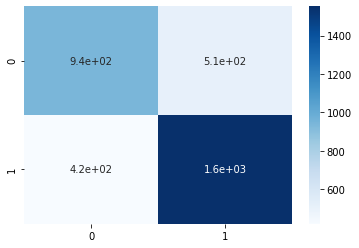

In [ ]:

historical.prepar_trian_test(step_size=4,deep=True , one_d=True)


historical.evaluat_LSTM(30,10,11,0.002,True,True)


Epoch 1/30
180/180 [==============================] - 3s 8ms/step - loss: 0.6762 - accuracy: 0.5980 - val_loss: 0.6464 - val_accuracy: 0.6837
Epoch 2/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6132 - accuracy: 0.6984 - val_loss: 0.5947 - val_accuracy: 0.6755
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5851 - accuracy: 0.7134 - val_loss: 0.5717 - val_accuracy: 0.7093
Epoch 4/30
180/180 [==============================] - 1s 8ms/step - loss: 0.5695 - accuracy: 0.7197 - val_loss: 0.5612 - val_accuracy: 0.7117
Epoch 5/30
180/180 [==============================] - 1s 6ms/step - loss: 0.5703 - accuracy: 0.7211 - val_loss: 0.5592 - val_accuracy: 0.7099
Epoch 6/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5565 - accuracy: 0.7381 - val_loss: 0.5690 - val_accuracy: 0.6950
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5512 - accuracy: 0.7294 - val_loss: 0.5647 - val_accuracy: 0.6968
Epoch 

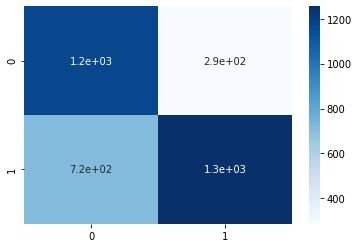

In [ ]:


historical.evaluat_GRU(30,10,11,0.002,True,True)



[0]	validation_0-auc:0.773429
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.792017
[2]	validation_0-auc:0.794543
[3]	validation_0-auc:0.792757
[4]	validation_0-auc:0.794315
[5]	validation_0-auc:0.793713
[6]	validation_0-auc:0.795303
[7]	validation_0-auc:0.792309
[8]	validation_0-auc:0.791646
[9]	validation_0-auc:0.792494
[10]	validation_0-auc:0.791967
[11]	validation_0-auc:0.791671
[12]	validation_0-auc:0.79101
[13]	validation_0-auc:0.789713
[14]	validation_0-auc:0.789972
[15]	validation_0-auc:0.789963
[16]	validation_0-auc:0.790109
[17]	validation_0-auc:0.789587
[18]	validation_0-auc:0.789863
[19]	validation_0-auc:0.789867
[20]	validation_0-auc:0.790219
[21]	validation_0-auc:0.790294
[22]	validation_0-auc:0.789215
[23]	validation_0-auc:0.789603
[24]	validation_0-auc:0.790933
[25]	validation_0-auc:0.789861
[26]	validation_0-auc:0.789366
[27]	validation_0-auc:0.789618
[28]	validation_0-auc:0.788911
[29]	validation_0-auc:0.78924
[30]	validation_0-

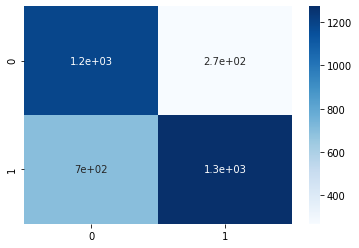

In [ ]:

historical.evaluat_XGboost(50,True)


In [ ]:
print(historical.tabel())

+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1 score      |          MI         |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|              LSTM             | 0.6768697660987583 | 0.7728983688833124 | 0.6194067370537959 | 0.6876918783142618 | 0.07114472032905816 |
|              GRU              | 0.6754259312734623 | 0.7742549143944197 | 0.6138763197586727 | 0.6848008973639932 | 0.07076860472204852 |
|            XGBoost            | 0.6832226393300607 | 0.7766749379652605 | 0.6294620412267471 | 0.6953623993335185 | 0.07550427427158055 |
|   LSTM with 44 previous data  | 0.7276967930029155 | 0.7512100677637947 | 0.7870182555780934 | 0.7686973749380882 | 0.09843729173121385 |
|   GRU with 44 prev

In [ ]:
res2[5]

['XGBoost with 44 previous data',
 0.7180758017492711,
 0.8260869565217391,
 0.6455375253549696,
 0.7247366922857956,
 0.11138000961283395]

In [ ]:

res2 = []
res2.append(historical.LSTM_result)
res2.append(historical.GRU_result)
res2.append(historical.XGboost_result)
res2.append(historical.LSTM_bata_result)
res2.append(historical.GRU_bata_result)
res2.append(historical.XGboost_bata_result)






In [ ]:
for x in res2:
  dic = {
    "Name": "004",
    "Model": x[0],
    "acc": x[1],
    "Perc": x[2] , 
    "recal": x[3] , 
    "f1" :x[4] , 
    "MI" : x[5]
  }
  Result = Result.append(dic,ignore_index=True)

##9001_china

In [ ]:

dfs = pd.read_excel("399001data.xlsx")


In [ ]:
dfs

DATE  openingprice  ...     volume       amounts
0    1991-04-03        988.05  ...          1         10000
1    1991-04-04        983.11  ...        523        761000
2    1991-04-05        978.27  ...        107        150000
3    1991-04-06        973.42  ...        102        159000
4    1991-04-08        968.57  ...         57         84000
...         ...           ...  ...        ...           ...
6804 2018-12-21       7399.15  ...  161299104  134924468224
6805 2018-12-24       7315.26  ...  143855088  127564046336
6806 2018-12-25       7308.61  ...  196583472  161164247040
6807 2018-12-26       7323.99  ...  161333008  137367527424
6808 2018-12-27       7402.60  ...  178064576  151452106752

[6809 rows x 7 columns]

In [ ]:


closing_price , label = visualize(dfs,'closingprice','DATE',0.25,100,6011)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=3011,test_index_end=6600)

#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=1,deep=True , one_d=True)



Epoch 1/30
182/182 [==============================] - 3s 9ms/step - loss: 0.6882 - accuracy: 0.5471 - val_loss: 0.6891 - val_accuracy: 0.4932
Epoch 2/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6379 - accuracy: 0.6332 - val_loss: 0.6505 - val_accuracy: 0.5937
Epoch 3/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6134 - accuracy: 0.6649 - val_loss: 0.6285 - val_accuracy: 0.6468
Epoch 4/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6129 - accuracy: 0.6674 - val_loss: 0.6259 - val_accuracy: 0.6530
Epoch 5/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6082 - accuracy: 0.6646 - val_loss: 0.6262 - val_accuracy: 0.6510
Epoch 6/30
182/182 [==============================] - 1s 8ms/step - loss: 0.6073 - accuracy: 0.6591 - val_loss: 0.6283 - val_accuracy: 0.6415
Epoch 7/30
182/182 [==============================] - 1s 8ms/step - loss: 0.6074 - accuracy: 0.6708 - val_loss: 0.6320 - val_accuracy: 0.6326
Epoch 

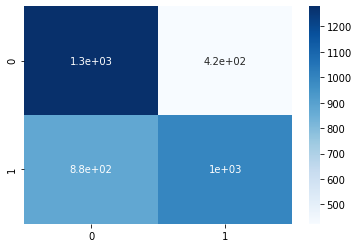

In [ ]:
historical.evaluat_LSTM(30,10,11,0.002,True,False)


Epoch 1/30
182/182 [==============================] - 2s 8ms/step - loss: 0.6753 - accuracy: 0.5888 - val_loss: 0.6633 - val_accuracy: 0.5812
Epoch 2/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6090 - accuracy: 0.6722 - val_loss: 0.6312 - val_accuracy: 0.6505
Epoch 3/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6099 - accuracy: 0.6684 - val_loss: 0.6326 - val_accuracy: 0.6510
Epoch 4/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6023 - accuracy: 0.6760 - val_loss: 0.6311 - val_accuracy: 0.6552
Epoch 5/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5949 - accuracy: 0.6815 - val_loss: 0.6323 - val_accuracy: 0.6376
Epoch 6/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5941 - accuracy: 0.6801 - val_loss: 0.6627 - val_accuracy: 0.5923
Epoch 7/30
182/182 [==============================] - 1s 7ms/step - loss: 0.5903 - accuracy: 0.6760 - val_loss: 0.6325 - val_accuracy: 0.6368
Epoch 

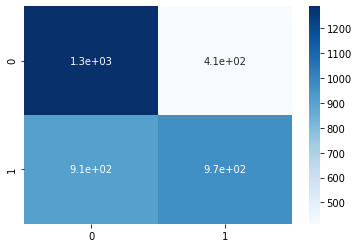

In [ ]:

historical.evaluat_GRU(30,10,11,0.002,True,False)




[0]	validation_0-auc:0.698863
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.700391
[2]	validation_0-auc:0.700862
[3]	validation_0-auc:0.708227
[4]	validation_0-auc:0.710582
[5]	validation_0-auc:0.710058
[6]	validation_0-auc:0.709861
[7]	validation_0-auc:0.710974
[8]	validation_0-auc:0.710826
[9]	validation_0-auc:0.711154
[10]	validation_0-auc:0.71397
[11]	validation_0-auc:0.714573
[12]	validation_0-auc:0.714681
[13]	validation_0-auc:0.716776
[14]	validation_0-auc:0.710772
[15]	validation_0-auc:0.712361
[16]	validation_0-auc:0.71229
[17]	validation_0-auc:0.713938
[18]	validation_0-auc:0.714009
[19]	validation_0-auc:0.716303
[20]	validation_0-auc:0.716569
[21]	validation_0-auc:0.71678
[22]	validation_0-auc:0.717574
[23]	validation_0-auc:0.717759
[24]	validation_0-auc:0.718123
[25]	validation_0-auc:0.71792
[26]	validation_0-auc:0.71794
[27]	validation_0-auc:0.717869
[28]	validation_0-auc:0.717857
[29]	validation_0-auc:0.718489
[30]	validation_0-auc

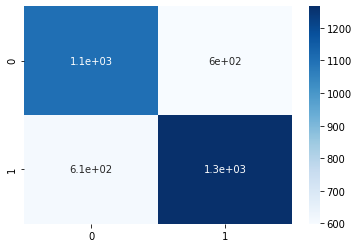

In [ ]:
historical.evaluat_XGboost(50,False)


Epoch 1/30
180/180 [==============================] - 3s 9ms/step - loss: 0.6625 - accuracy: 0.6102 - val_loss: 0.6396 - val_accuracy: 0.6354
Epoch 2/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6425 - accuracy: 0.6538 - val_loss: 0.6066 - val_accuracy: 0.6875
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6323 - accuracy: 0.6632 - val_loss: 0.5843 - val_accuracy: 0.7202
Epoch 4/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6337 - accuracy: 0.6639 - val_loss: 0.5842 - val_accuracy: 0.7081
Epoch 5/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6346 - accuracy: 0.6586 - val_loss: 0.5899 - val_accuracy: 0.7101
Epoch 6/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6270 - accuracy: 0.6639 - val_loss: 0.5853 - val_accuracy: 0.7152
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6137 - accuracy: 0.6775 - val_loss: 0.5833 - val_accuracy: 0.7335
Epoch 

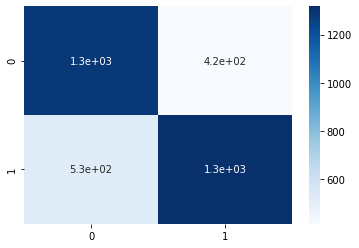

In [ ]:

historical.prepar_trian_test(step_size=4,deep=True , one_d=True)

historical.evaluat_LSTM(30,10,11,0.002,True,True)

Epoch 1/30
180/180 [==============================] - 3s 8ms/step - loss: 0.6624 - accuracy: 0.6321 - val_loss: 0.6477 - val_accuracy: 0.5846
Epoch 2/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6247 - accuracy: 0.6939 - val_loss: 0.5944 - val_accuracy: 0.7355
Epoch 3/30
180/180 [==============================] - 1s 8ms/step - loss: 0.5945 - accuracy: 0.6970 - val_loss: 0.5845 - val_accuracy: 0.6937
Epoch 4/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5805 - accuracy: 0.7172 - val_loss: 0.5707 - val_accuracy: 0.7053
Epoch 5/30
180/180 [==============================] - 1s 8ms/step - loss: 0.5753 - accuracy: 0.7075 - val_loss: 0.5793 - val_accuracy: 0.6833
Epoch 6/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5717 - accuracy: 0.7113 - val_loss: 0.5668 - val_accuracy: 0.7118
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5708 - accuracy: 0.7106 - val_loss: 0.5694 - val_accuracy: 0.6929
Epoch 

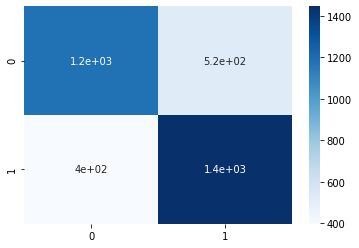

In [ ]:




historical.evaluat_GRU(30,10,11,0.002,True,True)




[0]	validation_0-auc:0.761407
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.786144
[2]	validation_0-auc:0.798737
[3]	validation_0-auc:0.798919
[4]	validation_0-auc:0.795991
[5]	validation_0-auc:0.798785
[6]	validation_0-auc:0.798533
[7]	validation_0-auc:0.800866
[8]	validation_0-auc:0.802755
[9]	validation_0-auc:0.802201
[10]	validation_0-auc:0.800814
[11]	validation_0-auc:0.802204
[12]	validation_0-auc:0.800764
[13]	validation_0-auc:0.801638
[14]	validation_0-auc:0.801645
[15]	validation_0-auc:0.803133
[16]	validation_0-auc:0.803482
[17]	validation_0-auc:0.802931
[18]	validation_0-auc:0.803762
[19]	validation_0-auc:0.804151
[20]	validation_0-auc:0.803872
[21]	validation_0-auc:0.803963
[22]	validation_0-auc:0.803658
[23]	validation_0-auc:0.803572
[24]	validation_0-auc:0.804728
[25]	validation_0-auc:0.804765
[26]	validation_0-auc:0.804622
[27]	validation_0-auc:0.804899
[28]	validation_0-auc:0.80446
[29]	validation_0-auc:0.804986
[30]	validation_0

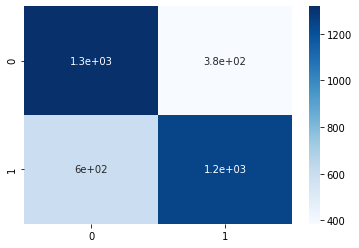

In [ ]:
historical.evaluat_XGboost(50,True)



In [ ]:
x= historical.tabel()
print(x)


res5 = []
res5.append(historical.LSTM_result)
res5.append(historical.GRU_result)
res5.append(historical.XGboost_result)
res5.append(historical.LSTM_bata_result)
res5.append(historical.GRU_bata_result)
res5.append(historical.XGboost_bata_result)




for x in res5:
  dic = {
    "Name": "99001",
    "Model": x[0],
    "acc": x[1],
    "Perc": x[2] , 
    "recal": x[3] , 
    "f1" :x[4] , 
    "MI" : x[5]
  }
  Result = Result.append(dic,ignore_index=True)

+-------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1 score      |          MI          |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
|              LSTM             | 0.636211232187762  | 0.7018284106891702 | 0.5319829424307037 | 0.6052152819890843 | 0.04261796272903495  |
|              GRU              | 0.6303436714165969 | 0.7002172338884866 | 0.5154584221748401 | 0.5937979735953332 | 0.039876456762144935 |
|            XGBoost            | 0.6621961441743504 | 0.6788203753351206 | 0.6748400852878464 | 0.6768243785084203 | 0.053082338896343034 |
|   LSTM with 44 previous data  | 0.7343485617597293 | 0.7599538372763993 | 0.7145957677699403 | 0.7365771812080537 | 0.11509162967168932  |
|   GRU with 

In [ ]:
for x in res5:
  dic = {
    "Name": "99001",
    "Model": x[0],
    "acc": x[1],
    "Perc": x[2] , 
    "recal": x[3] , 
    "f1" :x[4] , 
    "MI" : x[5]
  }
  Result = Result.append(dic,ignore_index=True)

## 601_china

In [ ]:

dfs = pd.read_excel("600601data.xlsx")


In [ ]:
dfs

DATE  openingprice  ...   volume       amounts
0    1990-12-19      185.3000  ...  50.0000  3.700000e+04
1    1990-12-20      185.3000  ...  21.0000  1.600000e+04
2    1990-12-21      204.3000  ...   8.0000  6.000000e+03
3    1990-12-26      236.5000  ...   2.0000  1.000000e+03
4    1990-12-28      238.9000  ...   5.0000  4.000000e+03
...         ...           ...  ...      ...           ...
6727 2018-12-21    16293.7157  ...   3.7707  8.852586e+07
6728 2018-12-24    16293.7157  ...   2.9126  7.211278e+07
6729 2018-12-25    16179.6501  ...   7.6241  1.619423e+08
6730 2018-12-26    15723.3877  ...   3.4680  8.251728e+07
6731 2018-12-27    15837.4533  ...   4.0636  9.390923e+07

[6732 rows x 7 columns]

In [ ]:


closing_price , label = visualize(dfs,'closingprice','DATE',0.3,100,6011)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=3011,test_index_end=6600)

#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=1,deep=True , one_d=True)



Epoch 1/30
182/182 [==============================] - 3s 9ms/step - loss: 0.6672 - accuracy: 0.5943 - val_loss: 0.6457 - val_accuracy: 0.6460
Epoch 2/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6320 - accuracy: 0.6680 - val_loss: 0.6232 - val_accuracy: 0.6591
Epoch 3/30
182/182 [==============================] - 2s 8ms/step - loss: 0.6283 - accuracy: 0.6749 - val_loss: 0.6224 - val_accuracy: 0.6658
Epoch 4/30
182/182 [==============================] - 1s 8ms/step - loss: 0.6221 - accuracy: 0.6760 - val_loss: 0.6179 - val_accuracy: 0.6628
Epoch 5/30
182/182 [==============================] - 1s 8ms/step - loss: 0.6182 - accuracy: 0.6763 - val_loss: 0.6198 - val_accuracy: 0.6636
Epoch 6/30
182/182 [==============================] - 1s 8ms/step - loss: 0.6195 - accuracy: 0.6839 - val_loss: 0.6157 - val_accuracy: 0.6658
Epoch 7/30
182/182 [==============================] - 1s 8ms/step - loss: 0.6158 - accuracy: 0.6825 - val_loss: 0.6188 - val_accuracy: 0.6636
Epoch 

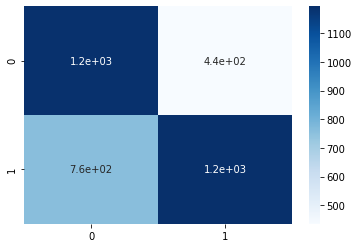

In [ ]:
historical.evaluat_LSTM(30,10,11,0.002,True,False)

Epoch 1/30
182/182 [==============================] - 3s 8ms/step - loss: 0.6675 - accuracy: 0.6084 - val_loss: 0.6426 - val_accuracy: 0.6563
Epoch 2/30
182/182 [==============================] - 1s 8ms/step - loss: 0.6278 - accuracy: 0.6718 - val_loss: 0.6221 - val_accuracy: 0.6686
Epoch 3/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6229 - accuracy: 0.6649 - val_loss: 0.6409 - val_accuracy: 0.6410
Epoch 4/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6198 - accuracy: 0.6774 - val_loss: 0.6180 - val_accuracy: 0.6597
Epoch 5/30
182/182 [==============================] - 1s 8ms/step - loss: 0.6126 - accuracy: 0.6756 - val_loss: 0.6184 - val_accuracy: 0.6633
Epoch 6/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6106 - accuracy: 0.6853 - val_loss: 0.6132 - val_accuracy: 0.6639
Epoch 7/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6038 - accuracy: 0.6839 - val_loss: 0.6122 - val_accuracy: 0.6681
Epoch 

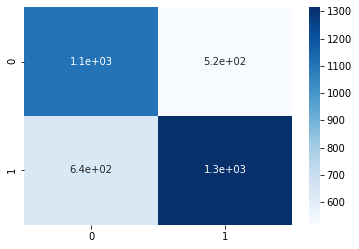

In [ ]:

historical.evaluat_GRU(30,10,11,0.002,True,False)



[0]	validation_0-auc:0.713866
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.713696
[2]	validation_0-auc:0.713654
[3]	validation_0-auc:0.718753
[4]	validation_0-auc:0.719354
[5]	validation_0-auc:0.72221
[6]	validation_0-auc:0.726653
[7]	validation_0-auc:0.726764
[8]	validation_0-auc:0.727787
[9]	validation_0-auc:0.726992
[10]	validation_0-auc:0.727864
[11]	validation_0-auc:0.730673
[12]	validation_0-auc:0.730981
[13]	validation_0-auc:0.731322
[14]	validation_0-auc:0.730841
[15]	validation_0-auc:0.730305
[16]	validation_0-auc:0.730574
[17]	validation_0-auc:0.730639
[18]	validation_0-auc:0.730829
[19]	validation_0-auc:0.730555
[20]	validation_0-auc:0.730484
[21]	validation_0-auc:0.730596
[22]	validation_0-auc:0.730421
[23]	validation_0-auc:0.730381
[24]	validation_0-auc:0.730276
[25]	validation_0-auc:0.730402
[26]	validation_0-auc:0.730122
[27]	validation_0-auc:0.730289
[28]	validation_0-auc:0.730524
[29]	validation_0-auc:0.730506
[30]	validation_0

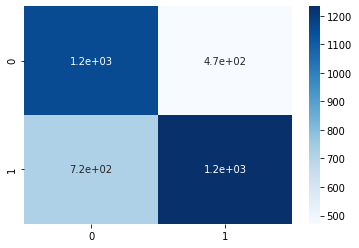

In [ ]:

historical.evaluat_XGboost(50,False)



Epoch 1/30
180/180 [==============================] - 3s 9ms/step - loss: 0.6898 - accuracy: 0.5387 - val_loss: 0.6730 - val_accuracy: 0.5849
Epoch 2/30
180/180 [==============================] - 1s 8ms/step - loss: 0.6619 - accuracy: 0.6273 - val_loss: 0.6509 - val_accuracy: 0.6255
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6411 - accuracy: 0.6611 - val_loss: 0.6381 - val_accuracy: 0.6348
Epoch 4/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6145 - accuracy: 0.6872 - val_loss: 0.6223 - val_accuracy: 0.6571
Epoch 5/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6045 - accuracy: 0.7012 - val_loss: 0.6096 - val_accuracy: 0.6712
Epoch 6/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5920 - accuracy: 0.7047 - val_loss: 0.6419 - val_accuracy: 0.6277
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5775 - accuracy: 0.7245 - val_loss: 0.6426 - val_accuracy: 0.6275
Epoch 

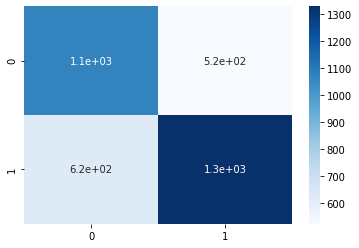

In [ ]:
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)


historical.evaluat_LSTM(30,10,11,0.002,True,True)




Epoch 1/30
180/180 [==============================] - 3s 9ms/step - loss: 0.6790 - accuracy: 0.5952 - val_loss: 0.6574 - val_accuracy: 0.6650
Epoch 2/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6424 - accuracy: 0.6918 - val_loss: 0.6324 - val_accuracy: 0.6469
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6152 - accuracy: 0.7029 - val_loss: 0.6148 - val_accuracy: 0.6754
Epoch 4/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6061 - accuracy: 0.7099 - val_loss: 0.6037 - val_accuracy: 0.6788
Epoch 5/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5928 - accuracy: 0.7183 - val_loss: 0.5801 - val_accuracy: 0.6988
Epoch 6/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5740 - accuracy: 0.7179 - val_loss: 0.5821 - val_accuracy: 0.6932
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.5742 - accuracy: 0.7141 - val_loss: 0.5810 - val_accuracy: 0.6842
Epoch 

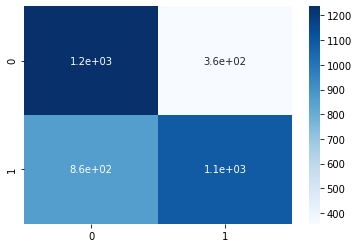

In [ ]:
historical.evaluat_GRU(30,10,11,0.002,True,True)

[0]	validation_0-auc:0.706973
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.72785
[2]	validation_0-auc:0.739823
[3]	validation_0-auc:0.73905
[4]	validation_0-auc:0.739796
[5]	validation_0-auc:0.746203
[6]	validation_0-auc:0.743934
[7]	validation_0-auc:0.74764
[8]	validation_0-auc:0.746428
[9]	validation_0-auc:0.746767
[10]	validation_0-auc:0.748524
[11]	validation_0-auc:0.750029
[12]	validation_0-auc:0.750029
[13]	validation_0-auc:0.749497
[14]	validation_0-auc:0.750426
[15]	validation_0-auc:0.749723
[16]	validation_0-auc:0.749259
[17]	validation_0-auc:0.750399
[18]	validation_0-auc:0.7515
[19]	validation_0-auc:0.750786
[20]	validation_0-auc:0.750515
[21]	validation_0-auc:0.751384
[22]	validation_0-auc:0.750839
[23]	validation_0-auc:0.75015
[24]	validation_0-auc:0.75032
[25]	validation_0-auc:0.750449
[26]	validation_0-auc:0.751123
[27]	validation_0-auc:0.750798
[28]	validation_0-auc:0.750454
[29]	validation_0-auc:0.751118
[30]	validation_0-auc:0

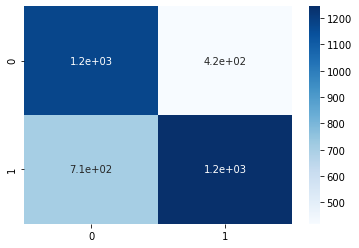

In [ ]:
historical.evaluat_XGboost(50,True)



In [ ]:
x= historical.tabel()
print(x)


res6 = []
res6.append(historical.LSTM_result)
res6.append(historical.GRU_result)
res6.append(historical.XGboost_result)
res6.append(historical.LSTM_bata_result)
res6.append(historical.GRU_bata_result)
res6.append(historical.XGboost_bata_result)




for x in res6:
  dic = {
    "Name": "601",
    "Model": x[0],
    "acc": x[1],
    "Perc": x[2] , 
    "recal": x[3] , 
    "f1" :x[4] , 
    "MI" : x[5]
  }
  Result = Result.append(dic,ignore_index=True)

+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1 score      |          MI         |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|              LSTM             | 0.6663872590108969 | 0.7329650092081031 | 0.6113671274961597 | 0.6666666666666666 | 0.06067083817048885 |
|              GRU              | 0.6767253422743783 | 0.7172489082969432 | 0.6728110599078341 | 0.6943196829590489 |  0.0635940038557786 |
|            XGBoost            | 0.6672254819782062 | 0.7235915492957746 | 0.631336405529954  | 0.6743232157506152 | 0.05938210619144493 |
|   LSTM with 44 previous data  | 0.676818950930626  | 0.7179902755267423 | 0.6804915514592934 | 0.6987381703470031 | 0.06297291764617596 |
|   GRU with 44 prev

In [ ]:
for x in res6:
  dic = {
    "Name": "601",
    "Model": x[0],
    "acc": x[1],
    "Perc": x[2] , 
    "recal": x[3] , 
    "f1" :x[4] , 
    "MI" : x[5]
  }
  Result = Result.append(dic,ignore_index=True)

## 615_china

In [ ]:

dfs = pd.read_excel("600615data.xlsx")


In [ ]:


closing_price , label = visualize(dfs,'closingprice','DATE',0.2,100,6011)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=3011,test_index_end=6600)

#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=1,deep=True , one_d=True)



Epoch 1/30
182/182 [==============================] - 3s 8ms/step - loss: 0.6929 - accuracy: 0.5164 - val_loss: 0.6946 - val_accuracy: 0.3820
Epoch 2/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6907 - accuracy: 0.5236 - val_loss: 0.6773 - val_accuracy: 0.6667
Epoch 3/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6479 - accuracy: 0.6391 - val_loss: 0.6157 - val_accuracy: 0.6724
Epoch 4/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6288 - accuracy: 0.6705 - val_loss: 0.6309 - val_accuracy: 0.6616
Epoch 5/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6314 - accuracy: 0.6656 - val_loss: 0.6021 - val_accuracy: 0.6748
Epoch 6/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6241 - accuracy: 0.6653 - val_loss: 0.6013 - val_accuracy: 0.6771
Epoch 7/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6229 - accuracy: 0.6722 - val_loss: 0.6023 - val_accuracy: 0.6785
Epoch 

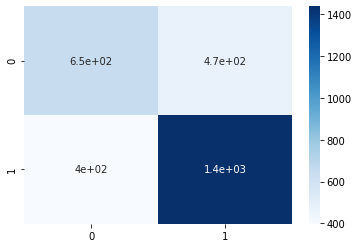

In [ ]:
historical.evaluat_LSTM(30,10,11,0.002,True,False)

Epoch 1/30
182/182 [==============================] - 3s 9ms/step - loss: 0.6817 - accuracy: 0.5853 - val_loss: 0.6476 - val_accuracy: 0.6545
Epoch 2/30
182/182 [==============================] - 1s 6ms/step - loss: 0.6615 - accuracy: 0.6522 - val_loss: 0.6387 - val_accuracy: 0.6741
Epoch 3/30
182/182 [==============================] - 1s 6ms/step - loss: 0.6403 - accuracy: 0.6680 - val_loss: 0.6065 - val_accuracy: 0.6900
Epoch 4/30
182/182 [==============================] - 1s 6ms/step - loss: 0.6180 - accuracy: 0.6880 - val_loss: 0.5861 - val_accuracy: 0.6961
Epoch 5/30
182/182 [==============================] - 1s 6ms/step - loss: 0.6058 - accuracy: 0.6853 - val_loss: 0.5734 - val_accuracy: 0.6974
Epoch 6/30
182/182 [==============================] - 1s 6ms/step - loss: 0.5941 - accuracy: 0.6863 - val_loss: 0.5755 - val_accuracy: 0.6981
Epoch 7/30
182/182 [==============================] - 1s 6ms/step - loss: 0.5932 - accuracy: 0.6849 - val_loss: 0.5789 - val_accuracy: 0.6937
Epoch 

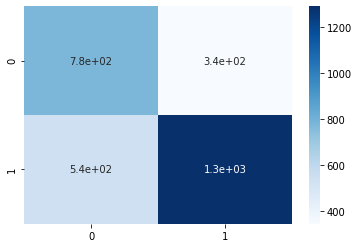

In [ ]:

historical.evaluat_GRU(30,10,11,0.002,True,False)


[0]	validation_0-auc:0.74486
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.75045
[2]	validation_0-auc:0.75374
[3]	validation_0-auc:0.752986
[4]	validation_0-auc:0.754266
[5]	validation_0-auc:0.75492
[6]	validation_0-auc:0.756184
[7]	validation_0-auc:0.75706
[8]	validation_0-auc:0.757557
[9]	validation_0-auc:0.759309
[10]	validation_0-auc:0.759644
[11]	validation_0-auc:0.760057
[12]	validation_0-auc:0.76118
[13]	validation_0-auc:0.761479
[14]	validation_0-auc:0.763264
[15]	validation_0-auc:0.763872
[16]	validation_0-auc:0.76397
[17]	validation_0-auc:0.764011
[18]	validation_0-auc:0.764275
[19]	validation_0-auc:0.764587
[20]	validation_0-auc:0.764941
[21]	validation_0-auc:0.765023
[22]	validation_0-auc:0.765814
[23]	validation_0-auc:0.766646
[24]	validation_0-auc:0.766315
[25]	validation_0-auc:0.766696
[26]	validation_0-auc:0.76705
[27]	validation_0-auc:0.767625
[28]	validation_0-auc:0.767856
[29]	validation_0-auc:0.768339
[30]	validation_0-auc:0.

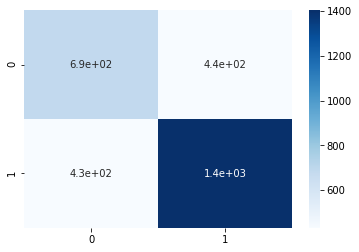

In [ ]:


historical.evaluat_XGboost(50,False)



Epoch 1/30
180/180 [==============================] - 3s 10ms/step - loss: 0.6932 - accuracy: 0.5185 - val_loss: 0.6768 - val_accuracy: 0.6232
Epoch 2/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6886 - accuracy: 0.5282 - val_loss: 0.6821 - val_accuracy: 0.6263
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6718 - accuracy: 0.6036 - val_loss: 0.6421 - val_accuracy: 0.6393
Epoch 4/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6401 - accuracy: 0.6492 - val_loss: 0.6250 - val_accuracy: 0.6619
Epoch 5/30
180/180 [==============================] - 2s 8ms/step - loss: 0.6223 - accuracy: 0.6667 - val_loss: 0.6460 - val_accuracy: 0.6595
Epoch 6/30
180/180 [==============================] - 2s 8ms/step - loss: 0.6167 - accuracy: 0.6628 - val_loss: 0.6459 - val_accuracy: 0.6578
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.6077 - accuracy: 0.6639 - val_loss: 0.6163 - val_accuracy: 0.6779
Epoch

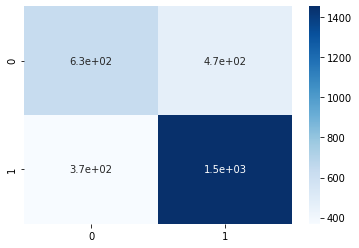

In [ ]:
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)


historical.evaluat_LSTM(30,10,11,0.002,True,True)


Epoch 1/30
180/180 [==============================] - 2s 8ms/step - loss: 0.6862 - accuracy: 0.5561 - val_loss: 0.6630 - val_accuracy: 0.6236
Epoch 2/30
180/180 [==============================] - 1s 6ms/step - loss: 0.6724 - accuracy: 0.5976 - val_loss: 0.6576 - val_accuracy: 0.6848
Epoch 3/30
180/180 [==============================] - 1s 6ms/step - loss: 0.6530 - accuracy: 0.6381 - val_loss: 0.6190 - val_accuracy: 0.6892
Epoch 4/30
180/180 [==============================] - 1s 6ms/step - loss: 0.6297 - accuracy: 0.6712 - val_loss: 0.6196 - val_accuracy: 0.6903
Epoch 5/30
180/180 [==============================] - 1s 6ms/step - loss: 0.6076 - accuracy: 0.6799 - val_loss: 0.6089 - val_accuracy: 0.6858
Epoch 6/30
180/180 [==============================] - 1s 6ms/step - loss: 0.5963 - accuracy: 0.6946 - val_loss: 0.5928 - val_accuracy: 0.6961
Epoch 7/30
180/180 [==============================] - 1s 6ms/step - loss: 0.5826 - accuracy: 0.6987 - val_loss: 0.5671 - val_accuracy: 0.7166
Epoch 

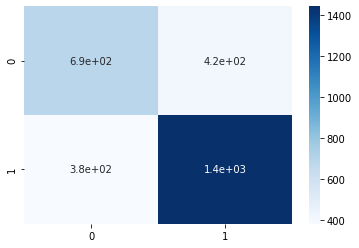

In [ ]:


historical.evaluat_GRU(30,10,11,0.002,True,True)


[0]	validation_0-auc:0.708246
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.70794
[2]	validation_0-auc:0.707825
[3]	validation_0-auc:0.720287
[4]	validation_0-auc:0.720099
[5]	validation_0-auc:0.720161
[6]	validation_0-auc:0.720953
[7]	validation_0-auc:0.722949
[8]	validation_0-auc:0.724154
[9]	validation_0-auc:0.723602
[10]	validation_0-auc:0.724803
[11]	validation_0-auc:0.727364
[12]	validation_0-auc:0.728686
[13]	validation_0-auc:0.729792
[14]	validation_0-auc:0.731271
[15]	validation_0-auc:0.732497
[16]	validation_0-auc:0.731655
[17]	validation_0-auc:0.732022
[18]	validation_0-auc:0.731768
[19]	validation_0-auc:0.73234
[20]	validation_0-auc:0.732747
[21]	validation_0-auc:0.733628
[22]	validation_0-auc:0.732803
[23]	validation_0-auc:0.735127
[24]	validation_0-auc:0.735072
[25]	validation_0-auc:0.734259
[26]	validation_0-auc:0.73456
[27]	validation_0-auc:0.735267
[28]	validation_0-auc:0.734743
[29]	validation_0-auc:0.736881
[30]	validation_0-a

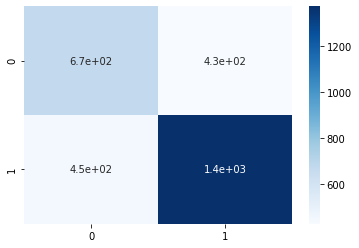

In [ ]:


historical.evaluat_XGboost(50,True)


In [ ]:

x= historical.tabel()
print(x)


res7 = []
res7.append(historical.LSTM_result)
res7.append(historical.GRU_result)
res7.append(historical.XGboost_result)
res7.append(historical.LSTM_bata_result)
res7.append(historical.GRU_bata_result)
res7.append(historical.XGboost_bata_result)




for x in res7:
  dic = {
    "Name": "615",
    "Model": x[0],
    "acc": x[1],
    "Perc": x[2] , 
    "recal": x[3] , 
    "f1" :x[4] , 
    "MI" : x[5]
  }
  Result = Result.append(dic,ignore_index=True)

+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1 score      |          MI         |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|              LSTM             | 0.7058823529411765 | 0.7527501309586171 | 0.7831062670299728 | 0.7676282051282051 | 0.06754608826897873 |
|              GRU              | 0.7004732927653821 | 0.7902140672782875 | 0.7040871934604904 | 0.7446685878962536 | 0.07716219181267198 |
|            XGBoost            | 0.7068965517241379 | 0.7633297062023939 | 0.7645776566757493 | 0.7639531717941737 | 0.07140292220792424 |
|   LSTM with 44 previous data  | 0.7135042735042735 | 0.7561102444097764 | 0.7975863960504662 | 0.776294714361986  | 0.07181571941273435 |
|   GRU with 44 prev

## Other

In [ ]:

dfs = pd.read_csv("خودرو.csv")


In [ ]:
dfs

id        date  ...    count      stock_id
0          305  2020-09-05  ...  83416.0  6.588384e+16
1          893  2020-09-05  ...  83416.0  6.588384e+16
2         1481  2020-09-05  ...  83416.0  6.588384e+16
3         2193  2020-09-06  ...   3272.0  6.588384e+16
4         2641  2020-09-06  ...   3272.0  6.588384e+16
...        ...         ...  ...      ...           ...
13197  8602728  2020-11-23  ...   7587.0  6.588384e+16
13198  8603314  2020-11-23  ...   8440.0  6.588384e+16
13199  8603903  2020-11-23  ...   8440.0  6.588384e+16
13200  8604494  2020-11-23  ...   9485.0  6.588384e+16
13201  8605086  2020-11-23  ...      NaN           NaN

[13202 rows x 13 columns]

In [ ]:
closing_price= dfs['last_price']
label=labeling(dfs['last_price'],0.05)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['date'][10:13000], y=dfs['last_price'][10:13000]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['date'][10:13000], y=label[10:13000])])
fig.show()

In [ ]:
historical = Train_data(closing_price,label,train_index_start=500,train_index_end=7000,test_index_end=12500)

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=10,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

[[3430 3430 3430 ... 3430 3410 3410]
 [3430 3430 3430 ... 3430 3410 3410]
 [3430 3430 3430 ... 3430 3410 3410]
 ...
 [3360 3360 3360 ... 3360 3360 3360]
 [3360 3360 3360 ... 3360 3360 3360]
 [3360 3360 3360 ... 3360 3360 3360]]
AAAA
[[3360 3360 3330 ... 3270 3270 3260]
 [3360 3360 3330 ... 3270 3270 3260]
 [3360 3360 3330 ... 3270 3260 3260]
 ...
 [3980 3980 3980 ... 3980 3980 3990]
 [3980 3980 3980 ... 3980 3980 3990]
 [3980 3980 3980 ... 3980 3980 3990]]
AAAA


Epoch 1/30
400/400 [==============================] - 3s 4ms/step - loss: 0.6819 - accuracy: 0.5591
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 0.6043 - accuracy: 0.6661
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5642 - accuracy: 0.7052
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5557 - accuracy: 0.7105
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5471 - accuracy: 0.7226
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5339 - accuracy: 0.7266
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5347 - accuracy: 0.7270
Epoch 8/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5340 - accuracy: 0.7256
Epoch 9/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5316 - accuracy: 0.7298
Epoch 10/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5276 - accuracy: 0.7362

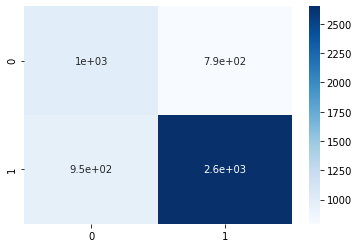

In [ ]:
historical.evaluat_GRU(30,10,11,0.002)

In [ ]:
dfs = pd.read_csv("فملی.csv")

In [ ]:
dfs

id        date  ...  count           stock_id
0           179  2020-09-05  ...  64652  35425587644337450
1           767  2020-09-05  ...  64652  35425587644337450
2          1355  2020-09-05  ...  64652  35425587644337450
3          2190  2020-09-06  ...   1552  35425587644337450
4          2638  2020-09-06  ...   1552  35425587644337450
...         ...         ...  ...    ...                ...
47554  29779295  2021-05-17  ...  11043  35425587644337450
47555  29779869  2021-05-17  ...  11043  35425587644337450
47556  29780443  2021-05-17  ...  11043  35425587644337450
47557  29781017  2021-05-17  ...  11043  35425587644337450
47558  29781591  2021-05-17  ...  11043  35425587644337450

[47559 rows x 13 columns]

In [ ]:
closing_price= dfs['last_price']
label=labeling(dfs['last_price'],0.1)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['date'][10:43000], y=dfs['last_price'][10:43000]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['date'][10:43000], y=label[10:43000])])
fig.show()

In [ ]:
historical = Train_data(closing_price,label,train_index_start=500,train_index_end=30000,test_index_end=40000)

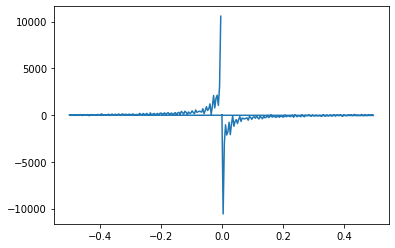

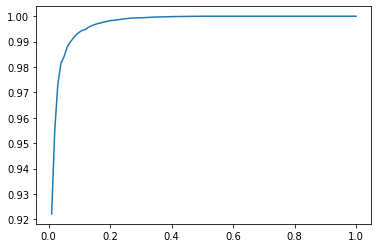

In [ ]:
a,b= historical.fft_analyse()

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

Epoch 1/10
1842/1842 [==============================] - 9s 4ms/step - loss: 0.6510 - accuracy: 0.6404
Epoch 2/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6293 - accuracy: 0.6541
Epoch 3/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6229 - accuracy: 0.6558
Epoch 4/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6184 - accuracy: 0.6547
Epoch 5/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6240 - accuracy: 0.6507
Epoch 6/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6238 - accuracy: 0.6530
Epoch 7/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6266 - accuracy: 0.6511
Epoch 8/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6201 - accuracy: 0.6558
Epoch 9/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6512 - accuracy: 0.6410
Epoch 10/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.650

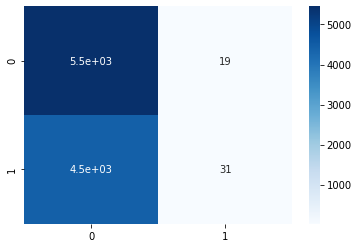

In [ ]:
historical.evaluat_GRU(10,10,11,0.02)

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test_with_smothing(step_size=9,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

In [ ]:
historical.evaluat_GRU(10,20,11,0.002,True)

Epoch 1/50
1838/1838 [==============================] - 11s 6ms/step - loss: 0.6228 - accuracy: 0.6677 - val_loss: 0.6656 - val_accuracy: 0.5897
Epoch 2/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.6042 - accuracy: 0.6824 - val_loss: 0.6644 - val_accuracy: 0.5920
Epoch 3/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5990 - accuracy: 0.6858 - val_loss: 0.6483 - val_accuracy: 0.6192
Epoch 4/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5895 - accuracy: 0.6885 - val_loss: 0.6681 - val_accuracy: 0.6021
Epoch 5/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5790 - accuracy: 0.6947 - val_loss: 0.6458 - val_accuracy: 0.6497
Epoch 6/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5743 - accuracy: 0.6954 - val_loss: 0.6730 - val_accuracy: 0.5808
Epoch 7/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5710 - accuracy: 0.6993 - val_loss: 0.6511 - val_ac

KeyboardInterrupt: ignored

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=9,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

Epoch 1/10
1838/1838 [==============================] - 13s 6ms/step - loss: 0.6203 - accuracy: 0.6683 - val_loss: 0.6618 - val_accuracy: 0.5861
Epoch 2/10
1838/1838 [==============================] - 10s 6ms/step - loss: 0.6056 - accuracy: 0.6798 - val_loss: 0.6731 - val_accuracy: 0.5813
Epoch 3/10
1838/1838 [==============================] - 11s 6ms/step - loss: 0.6026 - accuracy: 0.6817 - val_loss: 0.6481 - val_accuracy: 0.6177
Epoch 4/10
1838/1838 [==============================] - 10s 6ms/step - loss: 0.6008 - accuracy: 0.6827 - val_loss: 0.6712 - val_accuracy: 0.5802
Epoch 5/10
1838/1838 [==============================] - 10s 6ms/step - loss: 0.5982 - accuracy: 0.6853 - val_loss: 0.6567 - val_accuracy: 0.6073
Epoch 6/10
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5872 - accuracy: 0.6909 - val_loss: 0.6444 - val_accuracy: 0.6360
Epoch 7/10
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5748 - accuracy: 0.6985 - val_loss: 0.6677 - val_ac

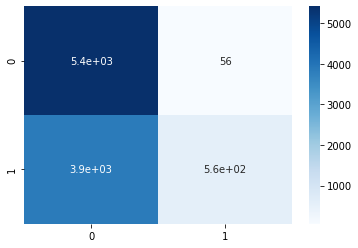

In [ ]:
historical.evaluat_GRU(10,20,11,0.002,True)


In [ ]:
dfs = pd.read_csv("HistoricalData_1627497050412.csv")
dfs = dfs[::-1].reset_index()

In [ ]:
dfs

index        Date  Close/Last Volume     Open     High      Low
0      2556  07/28/2011     1300.67     --  1304.84  1316.32  1299.16
1      2555  07/29/2011     1292.28     --  1300.12  1304.16  1282.86
2      2554  08/01/2011     1286.94     --  1292.59  1307.38  1274.73
3      2553  08/02/2011     1254.05     --  1286.56  1286.56  1254.03
4      2552  08/03/2011     1260.34     --  1254.25  1261.20  1234.56
...     ...         ...         ...    ...      ...      ...      ...
2552      4  07/21/2021     4358.69     --  4331.13  4359.70  4331.13
2553      3  07/22/2021     4367.48     --  4361.27  4369.87  4350.06
2554      2  07/23/2021     4411.79     --  4381.20  4415.18  4381.20
2555      1  07/26/2021     4422.30     --  4409.58  4422.73  4405.45
2556      0  07/27/2021     4401.46     --  4416.38  4416.38  4372.51

[2557 rows x 7 columns]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

In [ ]:
closing_price= dfs['Close/Last']
label=labeling(dfs['Close/Last'],0.15)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['Date'][10:2350], y=dfs['Close/Last'][10:2350]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['Date'][10:2350], y=label[10:2350])])
fig.show()

In [ ]:
historical = Train_data(closing_price,label,train_index_start=10,train_index_end=1800,test_index_end=2350)

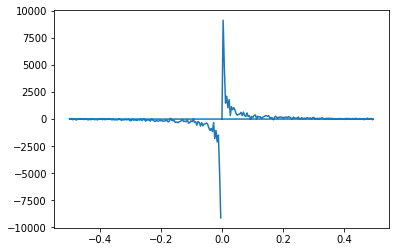

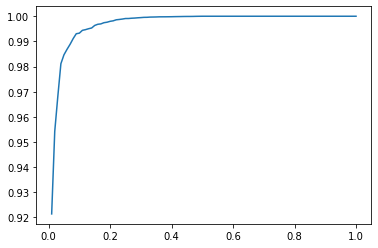

In [ ]:
a,b = historical.fft_analyse()

In [ ]:
def  buy_and_hold(pric , pred , index):
  i = 0
  for i,p in enumerate(pred):
    if p == 1 :
      break
  value = pric[index + i]
  a = 0 
  a=value
  i +=1
  for j in range(len(pred) - i):
    if pred[i + j] == 1:
      value = pric[i+j + index]
  return value / a  




In [ ]:
res1

[['LSTM',
  0.6932103939647947,
  0.7267525035765379,
  0.7437774524158126,
  0.7351664254703328,
  0.06980767426578705],
 ['GRU',
  0.694048616932104,
  0.7256385998107853,
  0.7486578818936066,
  0.7369685323084315,
  0.07014179124221728],
 ['XGBoost',
  0.6962838781782621,
  0.7294847328244275,
  0.7462176671547096,
  0.7377563329312424,
  0.07227621154066724],
 ['LSTM with 44 previous data',
  0.7340665538635082,
  0.7902023429179978,
  0.7299557304476144,
  0.7588851956021478,
  0.11227870960178662],
 ['GRU with 44 previous data',
  0.748448956570784,
  0.7532179316466933,
  0.8347270044269552,
  0.7918805412972468,
  0.11842825438932753],
 ['XGBoost with 44 previous data',
  0.7382966723068246,
  0.7921734531993654,
  0.7368421052631579,
  0.763506625891947,
  0.11610717913741953]]

In [ ]:
Result

MI                          Model  ...        f1     recal
0   0.060884                           LSTM  ...  0.679612  0.752688
1   0.065144                            GRU  ...  0.685990  0.763441
2   0.045411                        XGBoost  ...  0.678223  0.841398
3   0.096797     LSTM with 44 previous data  ...  0.670750  0.608333
4   0.112927      GRU with 44 previous data  ...  0.724044  0.736111
5   0.105471  XGBoost with 44 previous data  ...  0.718157  0.736111
6   0.046708                           LSTM  ...  0.573770  0.577558
7   0.052866                            GRU  ...  0.593997  0.620462
8   0.045725                        XGBoost  ...  0.511811  0.429043
9   0.075432     LSTM with 44 previous data  ...  0.525060  0.407407
10  0.112439      GRU with 44 previous data  ...  0.663004  0.670370
11  0.098931  XGBoost with 44 previous data  ...  0.628231  0.585185
12  0.069808                           LSTM  ...  0.735166  0.743777
13  0.070142                            GRU  ...  0.736969  0.748658
14  0.072276                        XGBoost  ...  0.737756  0.746218
15  0.112279     LSTM with 44 previous data  ...  0.758885  0.729956
16  0.118428      GRU with 44 previous data  ...  0.791881  0.834727
17  0.116107  XGBoost with 44 previous data  ...  0.763507  0.736842
18  0.071145                           LSTM  ...  0.687692  0.619407
19  0.070769                            GRU  ...  0.684801  0.613876
20  0.075504                        XGBoost  ...  0.695362  0.629462
21  0.098437     LSTM with 44 previous data  ...  0.768697  0.787018
22  0.100376      GRU with 44 previous data  ...  0.714286  0.636410
23  0.111380  XGBoost with 44 previous data  ...  0.724737  0.645538
24  0.042618                           LSTM  ...  0.605215  0.531983
25  0.039876                            GRU  ...  0.593798  0.515458
26  0.053082                        XGBoost  ...  0.676824  0.674840
27  0.115092     LSTM with 44 previous data  ...  0.736577  0.714596
28  0.120306      GRU with 44 previous data  ...  0.758856  0.784590
29  0.106421  XGBoost with 44 previous data  ...  0.718067  0.677157
30  0.060671                           LSTM  ...  0.666667  0.611367
31  0.063594                            GRU  ...  0.694320  0.672811
32  0.059382                        XGBoost  ...  0.674323  0.631336
33  0.062973     LSTM with 44 previous data  ...  0.698738  0.680492
34  0.059685      GRU with 44 previous data  ...  0.642164  0.559140
35  0.071544  XGBoost with 44 previous data  ...  0.688053  0.636969

[36 rows x 7 columns]

## Result

In [3]:
Result = pd.read_csv("result (1).csv")

In [4]:
Result

MI                          Model  ...        f1     recal
0   0.060884                           LSTM  ...  0.679612  0.752688
1   0.065144                            GRU  ...  0.685990  0.763441
2   0.045411                        XGBoost  ...  0.678223  0.841398
3   0.096797     LSTM with 44 previous data  ...  0.670750  0.608333
4   0.112927      GRU with 44 previous data  ...  0.724044  0.736111
5   0.105471  XGBoost with 44 previous data  ...  0.718157  0.736111
6   0.046708                           LSTM  ...  0.573770  0.577558
7   0.052866                            GRU  ...  0.593997  0.620462
8   0.045725                        XGBoost  ...  0.511811  0.429043
9   0.075432     LSTM with 44 previous data  ...  0.525060  0.407407
10  0.112439      GRU with 44 previous data  ...  0.663004  0.670370
11  0.098931  XGBoost with 44 previous data  ...  0.628231  0.585185
12  0.069808                           LSTM  ...  0.735166  0.743777
13  0.070142                            GRU  ...  0.736969  0.748658
14  0.072276                        XGBoost  ...  0.737756  0.746218
15  0.112279     LSTM with 44 previous data  ...  0.758885  0.729956
16  0.118428      GRU with 44 previous data  ...  0.791881  0.834727
17  0.116107  XGBoost with 44 previous data  ...  0.763507  0.736842
18  0.071145                           LSTM  ...  0.687692  0.619407
19  0.070769                            GRU  ...  0.684801  0.613876
20  0.075504                        XGBoost  ...  0.695362  0.629462
21  0.098437     LSTM with 44 previous data  ...  0.768697  0.787018
22  0.100376      GRU with 44 previous data  ...  0.714286  0.636410
23  0.111380  XGBoost with 44 previous data  ...  0.724737  0.645538
24  0.042618                           LSTM  ...  0.605215  0.531983
25  0.039876                            GRU  ...  0.593798  0.515458
26  0.053082                        XGBoost  ...  0.676824  0.674840
27  0.115092     LSTM with 44 previous data  ...  0.736577  0.714596
28  0.120306      GRU with 44 previous data  ...  0.758856  0.784590
29  0.106421  XGBoost with 44 previous data  ...  0.718067  0.677157
30  0.060671                           LSTM  ...  0.666667  0.611367
31  0.063594                            GRU  ...  0.694320  0.672811
32  0.059382                        XGBoost  ...  0.674323  0.631336
33  0.062973     LSTM with 44 previous data  ...  0.698738  0.680492
34  0.059685      GRU with 44 previous data  ...  0.642164  0.559140
35  0.071544  XGBoost with 44 previous data  ...  0.688053  0.636969
36  0.067546                           LSTM  ...  0.767628  0.783106
37  0.077162                            GRU  ...  0.744669  0.704087
38  0.071403                        XGBoost  ...  0.763953  0.764578
39  0.071816     LSTM with 44 previous data  ...  0.776295  0.797586
40  0.086645      GRU with 44 previous data  ...  0.783152  0.790455
41  0.065606  XGBoost with 44 previous data  ...  0.757174  0.752606

[42 rows x 7 columns]

In [ ]:
Result.to_csv('result.csv', index = False)